In [1]:
# from circuit_breaking.src import *
%load_ext autoreload
%autoreload 2
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
print(os.getcwd())
import sys
from transformers import AutoTokenizer, AutoModelForCausalLM
import contextlib
import einops
import wandb
import pandas as pd
import dotenv
from collections import defaultdict
dotenv.load_dotenv()
import math
from huggingface_hub import login

HF_ACCESS_TOKEN = os.getenv("HF_ACCESS_TOKEN")
WANDB_API_KEY = os.getenv("WANDB_API_KEY")
if HF_ACCESS_TOKEN:
    login(token=HF_ACCESS_TOKEN)
    print("Successfully authenticated with Hugging Face.")
else:
    print("Hugging Face access token not found in environment variables.")

if WANDB_API_KEY:
    os.environ["WANDB_API_KEY"] = WANDB_API_KEY
    print("Successfully authenticated with Weights & Biases.")
else:
    print("Weights & Biases API key not found in environment variables.")


/root/sae-editing
Successfully authenticated with Hugging Face.
Successfully authenticated with Weights & Biases.


In [2]:
model_name_or_path = "google/gemma-2-9b"
model_type = "gemma-2"
other_model_type = "gemma2_9b"
# pretrained_path = "/data/huggingface/models--google--gemma-2-9b/snapshots/33c193028431c2fde6c6e51f29e6f17b60cbfac6/"
# pretrained_path = "/data/huggingface/models--google--gemma-2-9b-it/snapshots/11c9b309abf73637e4b6f9a3fa1e92e615547819/"
pretrained_path = None

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

left_tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
left_tokenizer.pad_token_id = left_tokenizer.eos_token_id
left_tokenizer.padding_side = "left"

dtype = torch.bfloat16
if pretrained_path is not None:
    model = AutoModelForCausalLM.from_pretrained(pretrained_path, torch_dtype=dtype)
else:
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=dtype)
model.cuda()
n_layers = 42
n_heads = 16
n_kv_heads = 8

param_count_dict = {"attn.hook_q": 3584*4096, "attn.hook_k": 3584*2048, "attn.hook_v": 3584*2048, "attn.hook_result": 4096*3584, "mlp.hook_pre": 3584 * 14336, "mlp.hook_post": 14336 * 3584, "mlp.hook_gate": 3584 * 14336}
mmlu_batch_size = 2

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
from sae_lens import SAE

sae_type = "16k"
# sae_layer = 21

sae_dict = {}

sae_layers = list(range(42))
# 3.76 gb + .47 gb = 4.23 gb
for layer in tqdm(sae_layers):
    if sae_type == "131k":
        sae, cfg_dict, sparsity = SAE.from_pretrained(
            release = "gemma-scope-9b-pt-res-canonical", # e.g., "gpt2-small-res-jb". See other options in https://github.com/jbloomAus/SAELens/blob/main/sae_lens/pretrained_saes.yaml
            sae_id = f"layer_{layer}/width_131k/canonical", # e.g., "blocks.8.hook_resid_pre". Won't always be a hook point
        )
    elif sae_type == "16k":
        sae, cfg_dict, sparsity = SAE.from_pretrained(
            release = "gemma-scope-9b-pt-res-canonical", # e.g., "gpt2-small-res-jb". See other options in https://github.com/jbloomAus/SAELens/blob/main/sae_lens/pretrained_saes.yaml
            sae_id = f"layer_{layer}/width_16k/canonical", # e.g., "blocks.8.hook_resid_pre". Won't always be a hook point
        )
    
    # for param in sae.parameters():
    #     param.data = param.data.to(torch.bfloat16)

    sae_dict[layer] = sae.cuda()


  0%|          | 0/42 [00:00<?, ?it/s]

In [4]:
from tasks.wmdp.WMDP_UnlearnTask import WMDP_UnlearnTask, WMDP_UnlearnMCTask
batch_size = 8
split = "all_splits_train_heavy"
bio_task = WMDP_UnlearnTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=False, split=split, train_test_split=False, criterion="cross_entropy", injection_task=False, model_type="gemma-2", filter_correct_prob_threshold=0.5)
injection_bio_task = WMDP_UnlearnTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=False, split=split, train_test_split=False, criterion="cross_entropy", injection_task=True, model_type="gemma-2", filter_correct_prob_threshold=0.5)

num_batches = int(math.ceil(len(bio_task.train_dataset) / batch_size))
bio_mc_task = WMDP_UnlearnMCTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=False, split=split, train_test_split=False, criterion="cross_entropy", injection_task=False, model_type="gemma-2", filter_correct_prob_threshold=0.5)
# print(bio_mc_task.get_test_accuracy(model, n_iters=10, continuous=True))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Parameter 'function'=<bound method WMDP_UnlearnMCTask.format_row of <tasks.wmdp.WMDP_UnlearnTask.WMDP_UnlearnMCTask object at 0x7fd722a75580>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/164 [00:00<?, ? examples/s]

Map:   0%|          | 0/164 [00:00<?, ? examples/s]

## Feature Sparsities and Cooccurrences

In [5]:
def get_batch_sae_acts(batch, sae_layers, sae_dict, concatenate_batch_together=True):
    tokenized_batch = tokenizer(bio_batch["prompt"], return_tensors="pt", padding=True, truncation=True, max_length=100)
    output = model(tokenized_batch["input_ids"].cuda(), attention_mask=tokenized_batch["attention_mask"].cuda(), output_hidden_states=True)
    if concatenate_batch_together:
        acts = {}
        sae_acts = {}
        for layer in sae_layers:
            # num_subject_tokens = 0
            total_hidden_states = output.hidden_states[layer+1]
            answer_hidden_states = []
            for i in range(len(total_hidden_states)):
                answer_hidden_states.append(total_hidden_states[i][batch["target_start"][i]:batch["target_end"][i]-1])
            acts[layer] = torch.cat(answer_hidden_states, dim=0)
            sae_acts[layer] = sae_dict[layer].encode(acts[layer])
    else:
        acts = defaultdict(list)
        sae_acts = defaultdict(list)
        for layer in sae_layers:
            # num_subject_tokens = 0
            total_hidden_states = output.hidden_states[layer+1]
            answer_hidden_states = []
            for i in range(len(total_hidden_states)):
                prompt_acts = total_hidden_states[i][batch["target_start"][i]:batch["target_end"][i]-1]
                acts[layer].append(prompt_acts)
                sae_acts[layer].append(sae_dict[layer].encode(prompt_acts))
    return sae_acts


all_bio_sae_acts = defaultdict(list)
all_injection_sae_acts = defaultdict(list)
with torch.no_grad():
    for batch_idx in tqdm(range(num_batches)):
        bio_batch = bio_task.get_batch()
        injection_batch = injection_bio_task.get_batch()
        bio_sae_acts = get_batch_sae_acts(bio_batch, sae_layers, sae_dict)
        injection_sae_acts = get_batch_sae_acts(injection_batch, sae_layers, sae_dict)
        
        for layer in sae_layers:
            all_bio_sae_acts[layer].append(bio_sae_acts[layer])
            all_injection_sae_acts[layer].append(injection_sae_acts[layer])


for layer in sae_layers:
    all_bio_sae_acts[layer] = torch.cat(all_bio_sae_acts[layer], dim=0)
    all_injection_sae_acts[layer] = torch.cat(all_injection_sae_acts[layer], dim=0)


  0%|          | 0/21 [00:00<?, ?it/s]

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.



Layer 2 statistics:
Mean bio sparsity: 0.0062
Mean injection sparsity: 0.0062
Mean absolute difference: 0.0010
Max absolute difference: 0.0710

Layer 3 statistics:
Mean bio sparsity: 0.0083
Mean injection sparsity: 0.0082
Mean absolute difference: 0.0011
Max absolute difference: 0.0801

Layer 4 statistics:
Mean bio sparsity: 0.0079
Mean injection sparsity: 0.0078
Mean absolute difference: 0.0011
Max absolute difference: 0.0800

Layer 5 statistics:
Mean bio sparsity: 0.0063
Mean injection sparsity: 0.0063
Mean absolute difference: 0.0010
Max absolute difference: 0.0856

Layer 6 statistics:
Mean bio sparsity: 0.0076
Mean injection sparsity: 0.0075
Mean absolute difference: 0.0011
Max absolute difference: 0.0534

Layer 7 statistics:
Mean bio sparsity: 0.0073
Mean injection sparsity: 0.0071
Mean absolute difference: 0.0010
Max absolute difference: 0.0892

Layer 8 statistics:
Mean bio sparsity: 0.0077
Mean injection sparsity: 0.0076
Mean absolute difference: 0.0011
Max absolute difference:

/tmp/ipykernel_146901/2541474918.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))



Layer 24 statistics:
Mean bio sparsity: 0.0078
Mean injection sparsity: 0.0077
Mean absolute difference: 0.0011
Max absolute difference: 0.0625

Layer 25 statistics:
Mean bio sparsity: 0.0078
Mean injection sparsity: 0.0077
Mean absolute difference: 0.0011
Max absolute difference: 0.0711

Layer 26 statistics:
Mean bio sparsity: 0.0081
Mean injection sparsity: 0.0080
Mean absolute difference: 0.0010
Max absolute difference: 0.0541

Layer 27 statistics:
Mean bio sparsity: 0.0080
Mean injection sparsity: 0.0079
Mean absolute difference: 0.0010
Max absolute difference: 0.0541


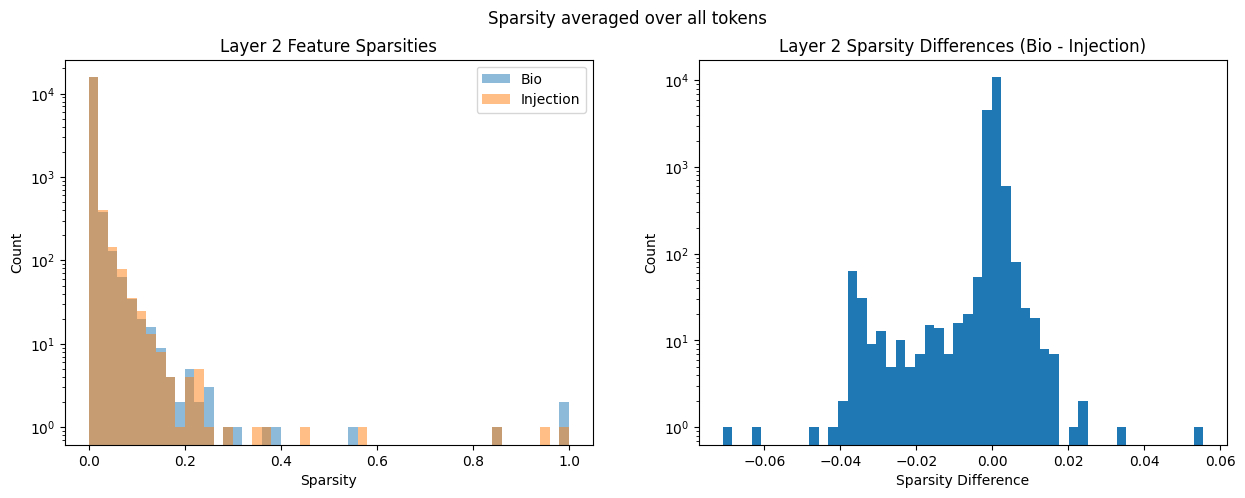

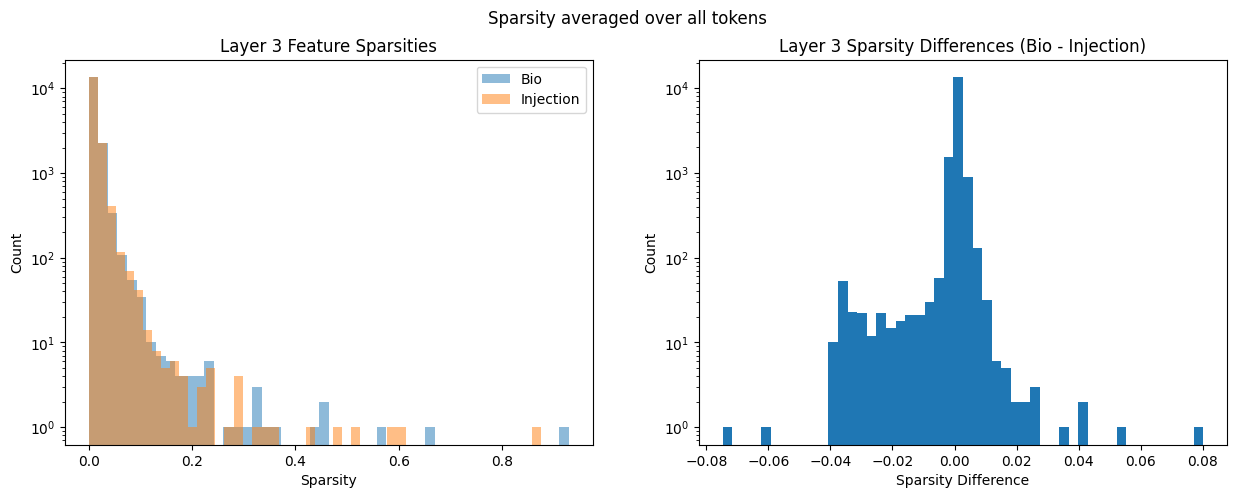

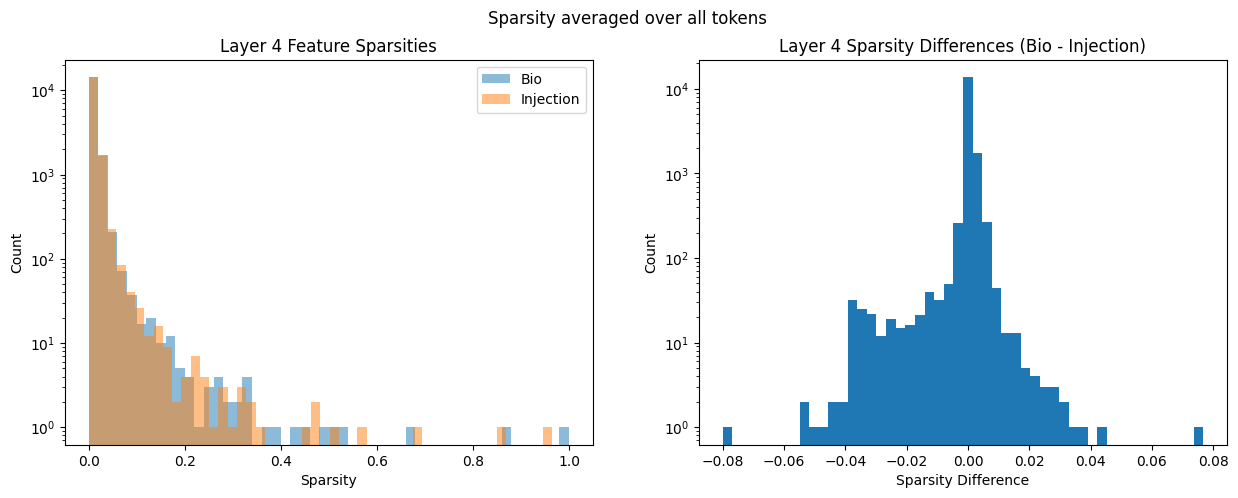

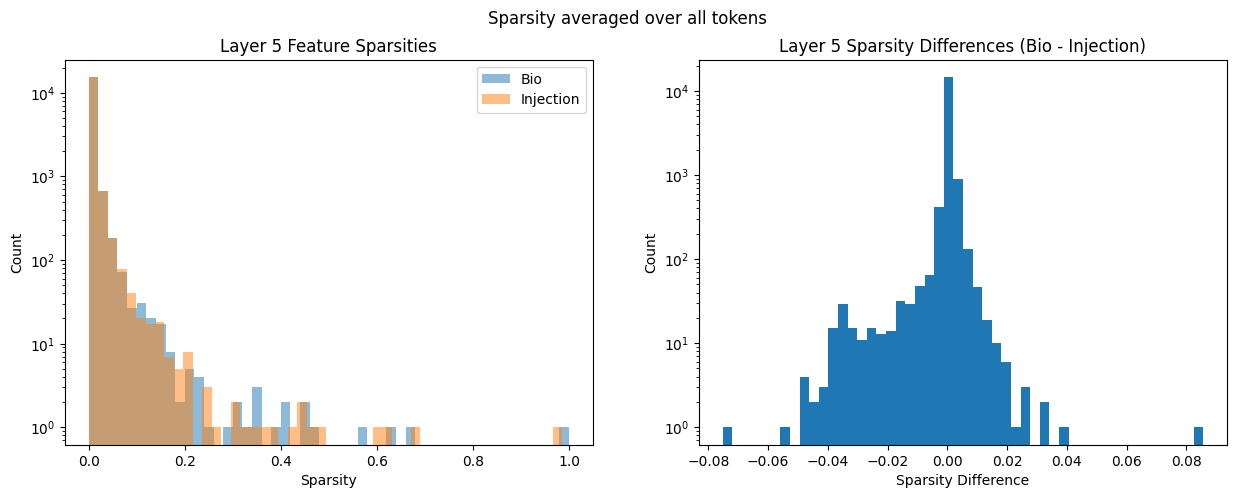

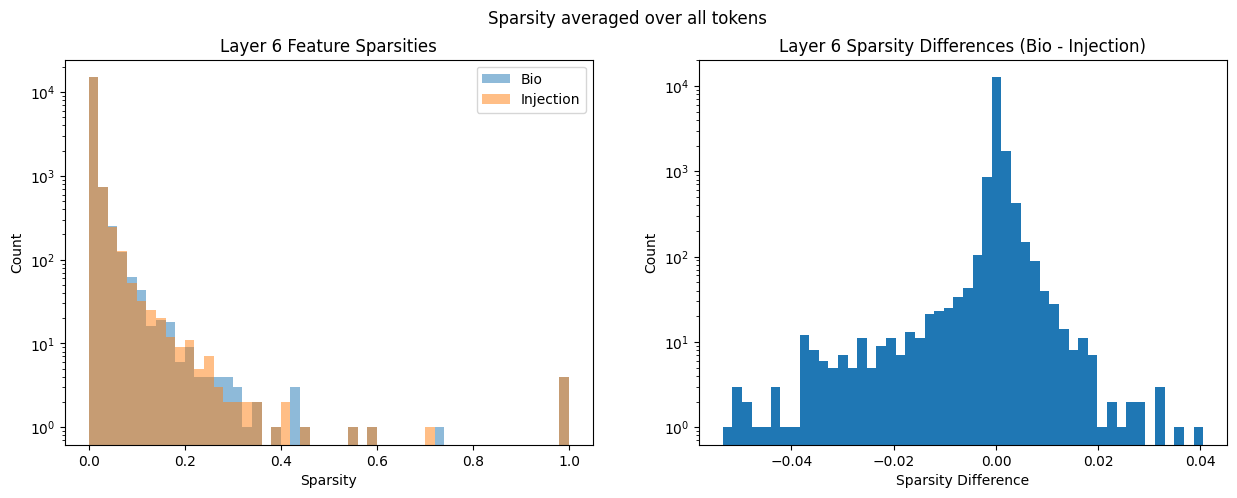

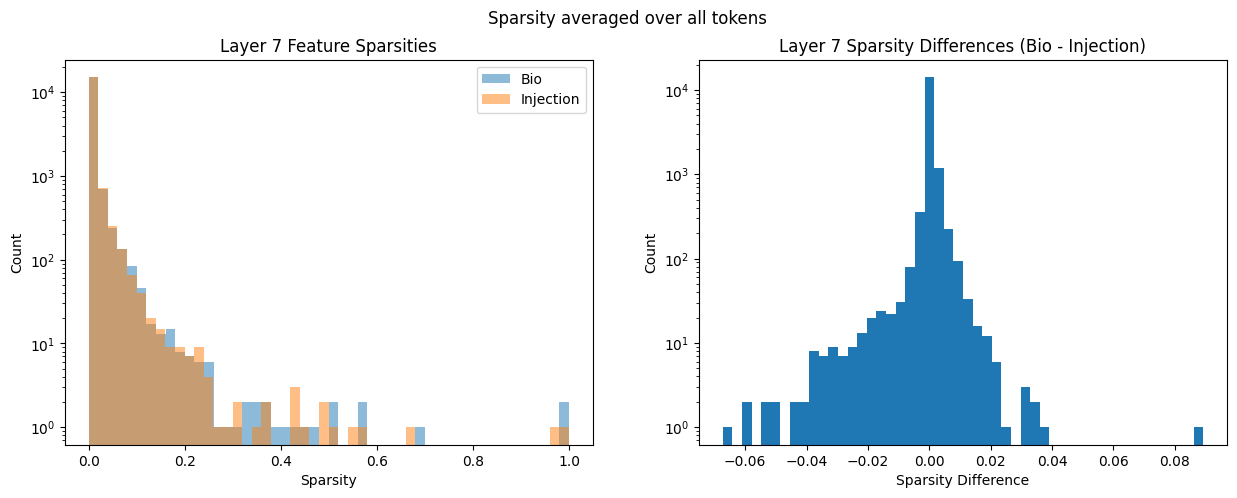

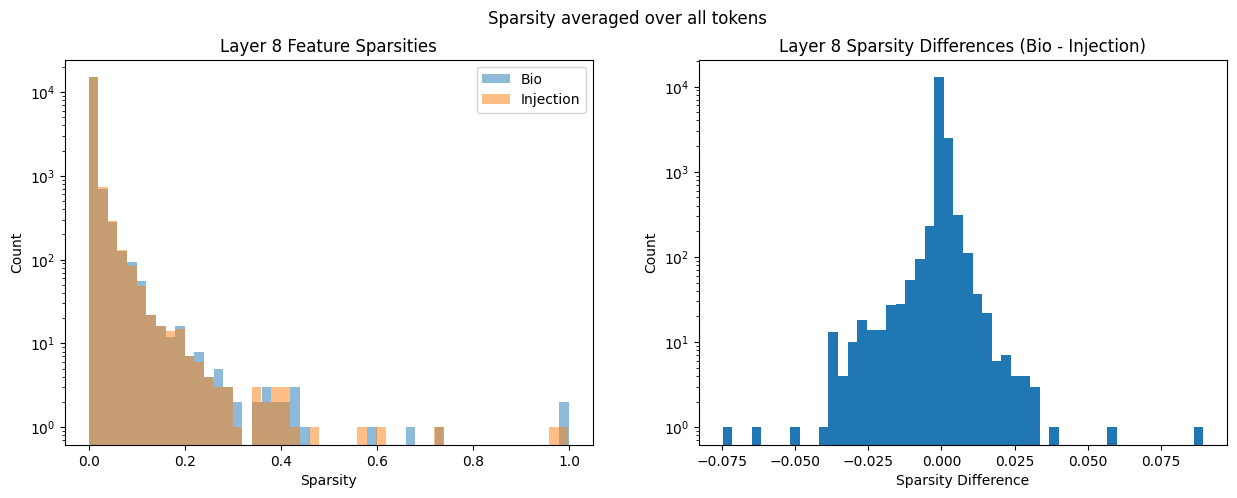

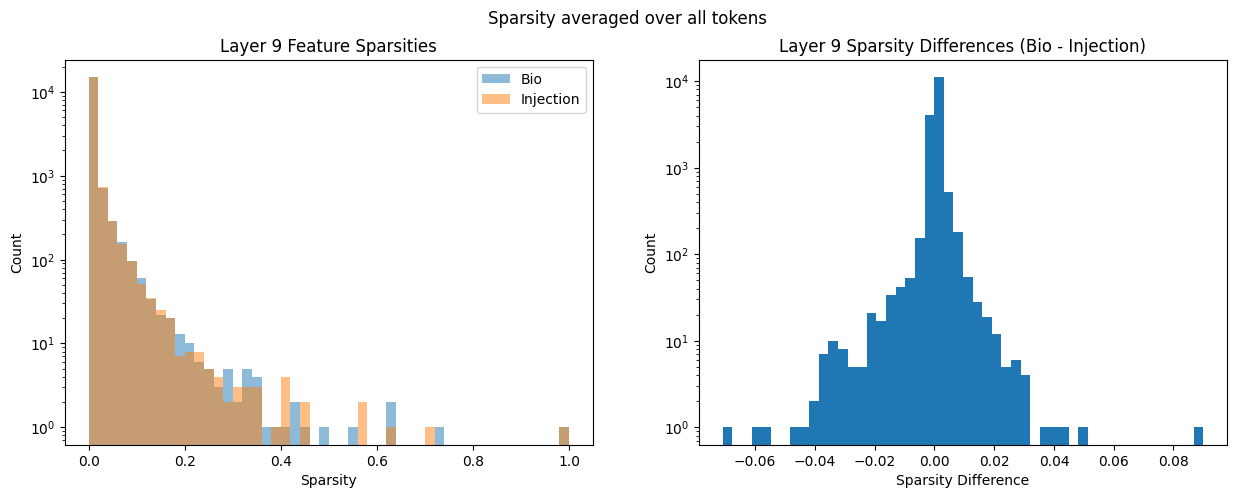

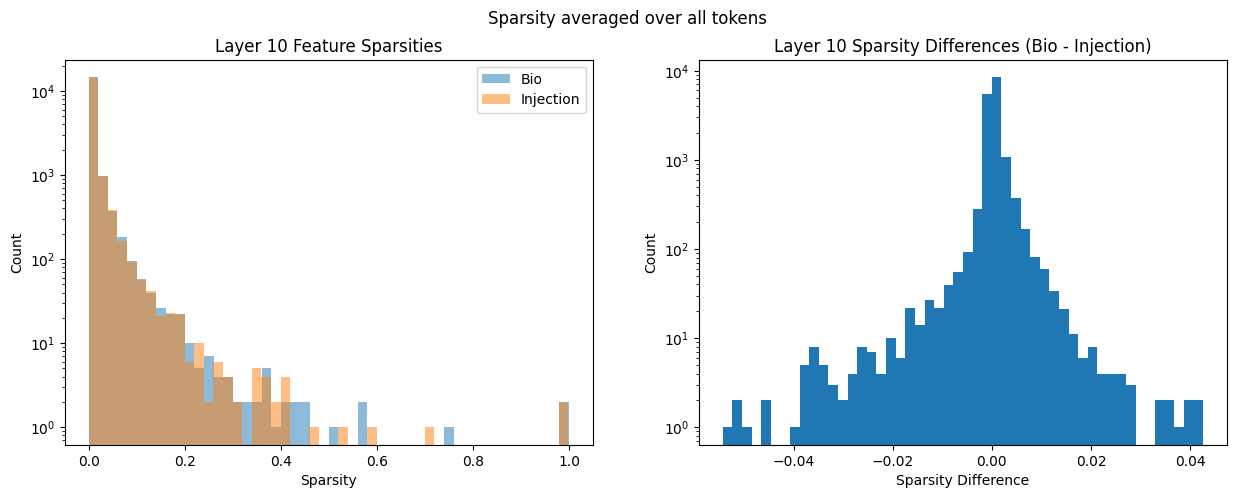

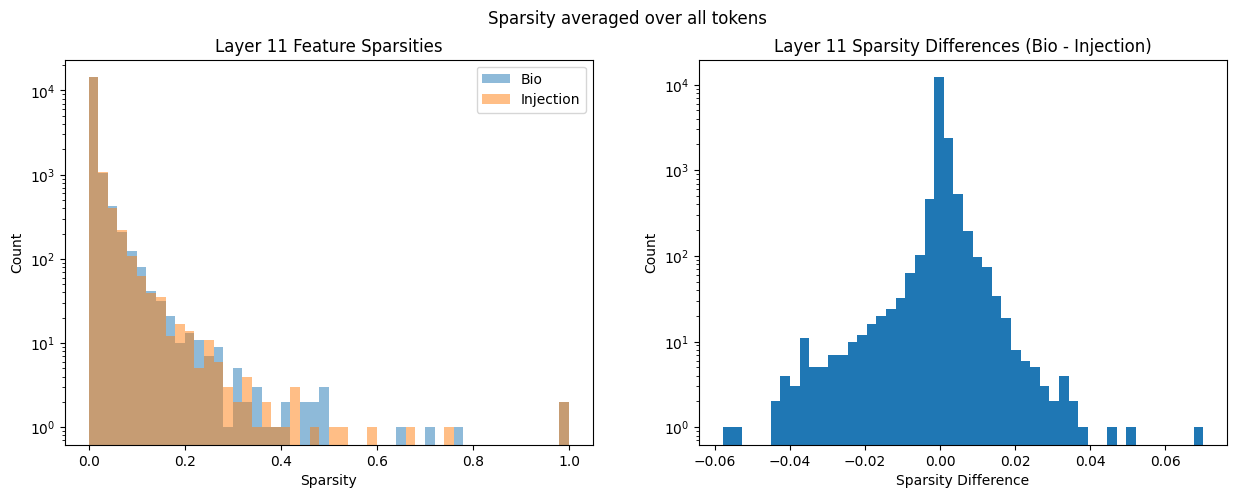

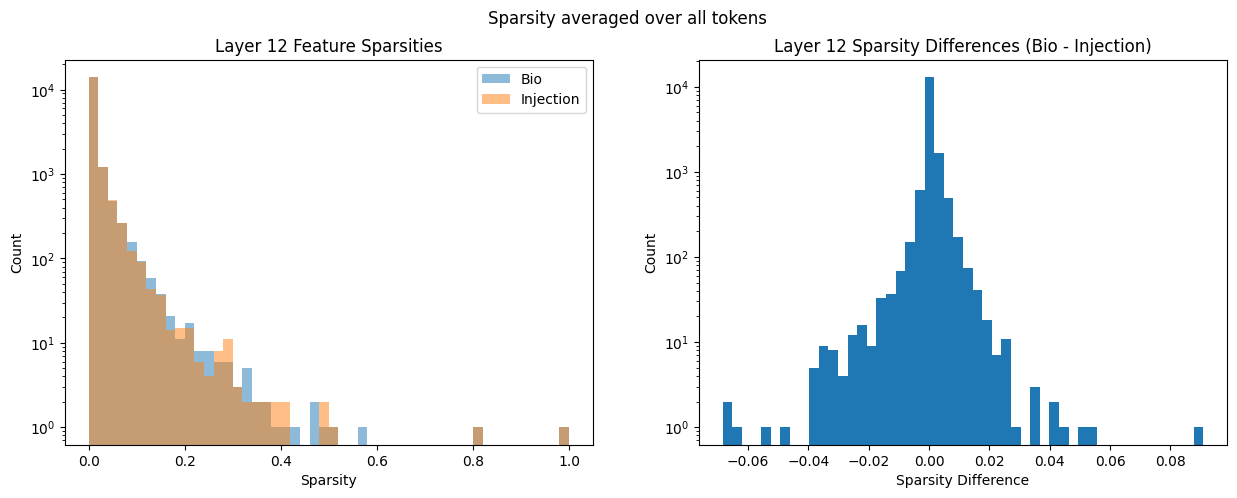

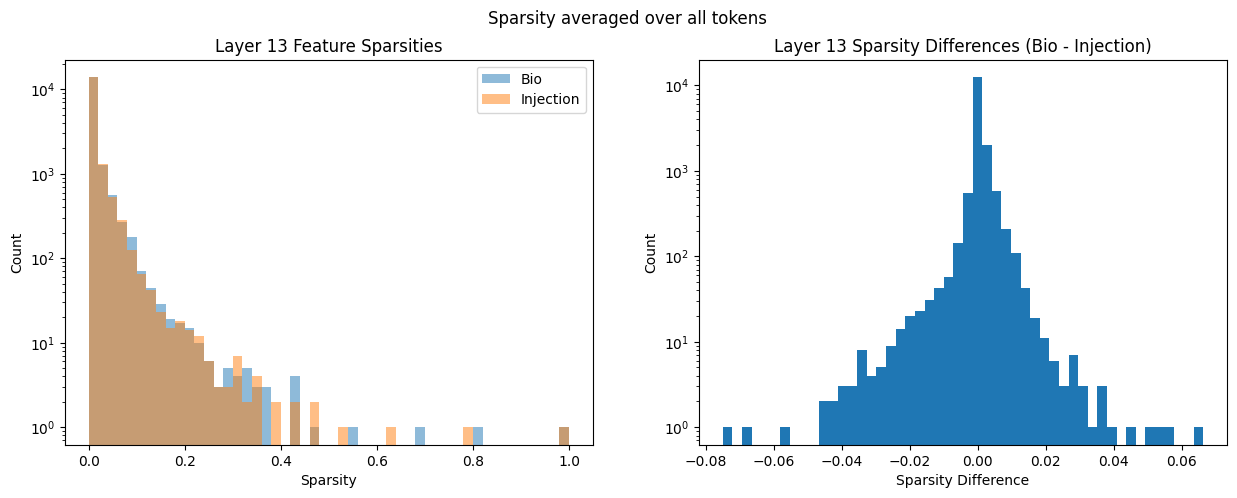

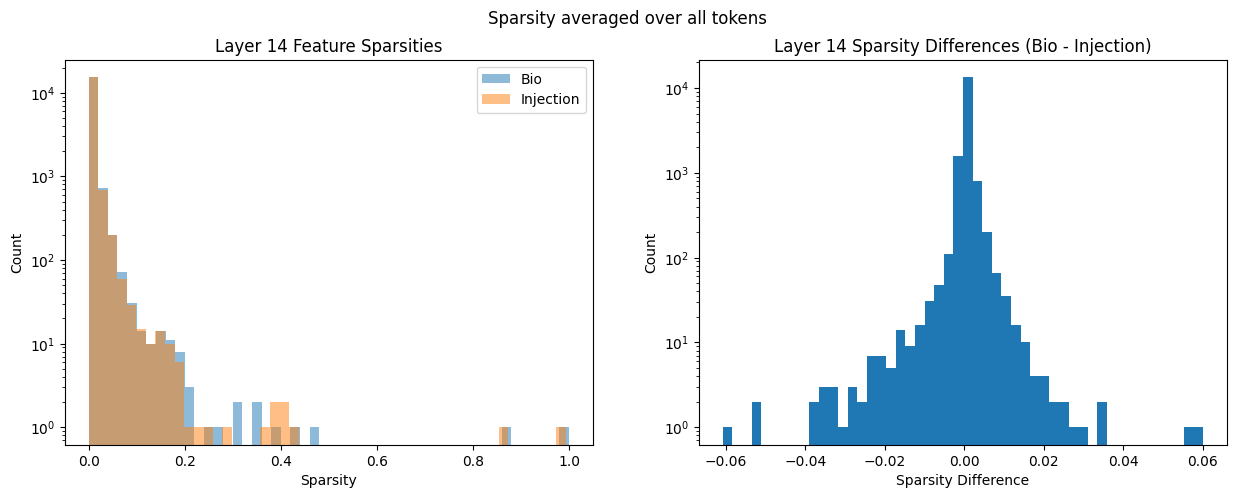

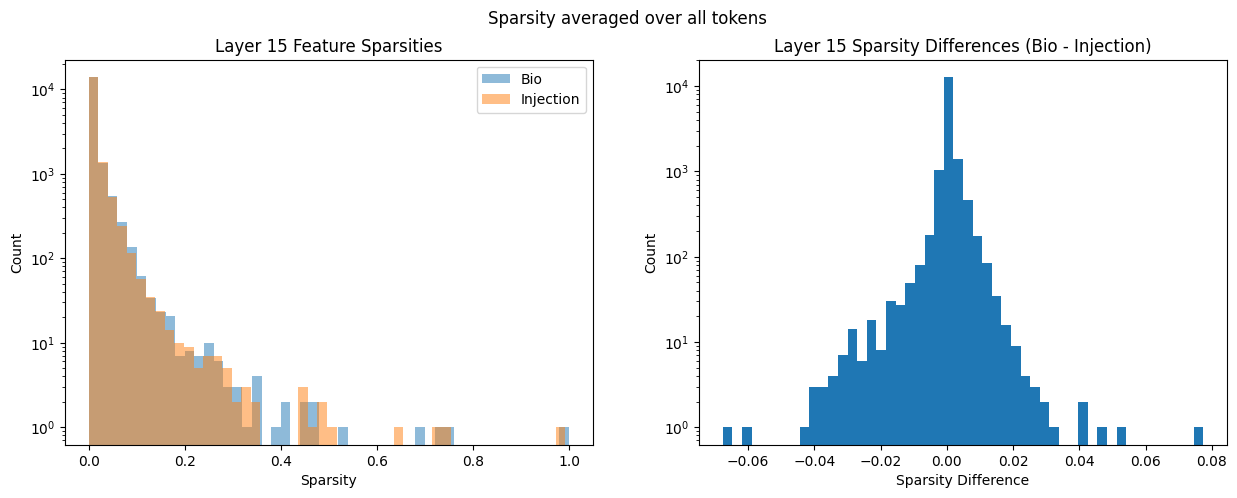

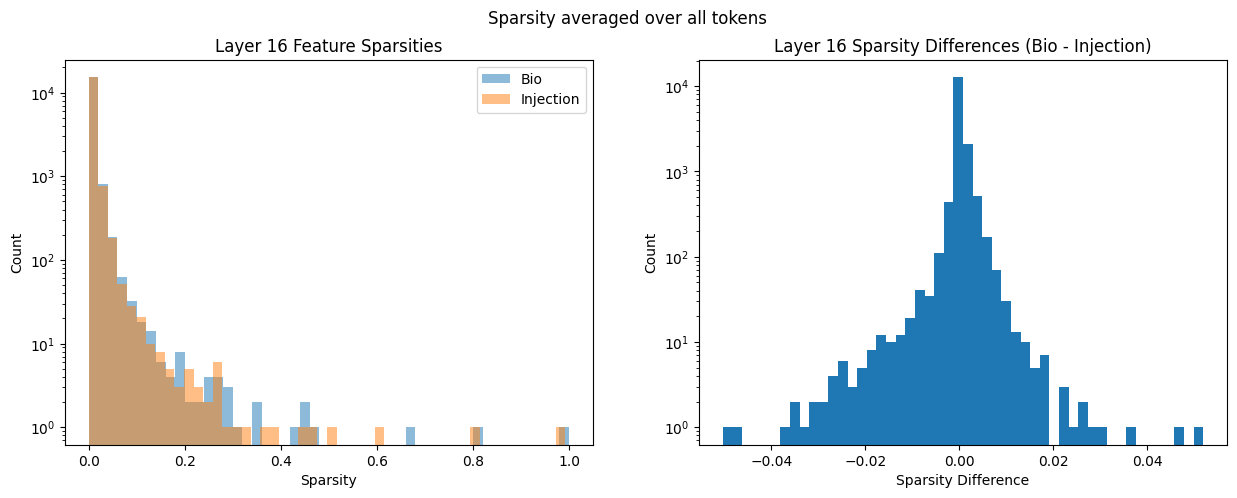

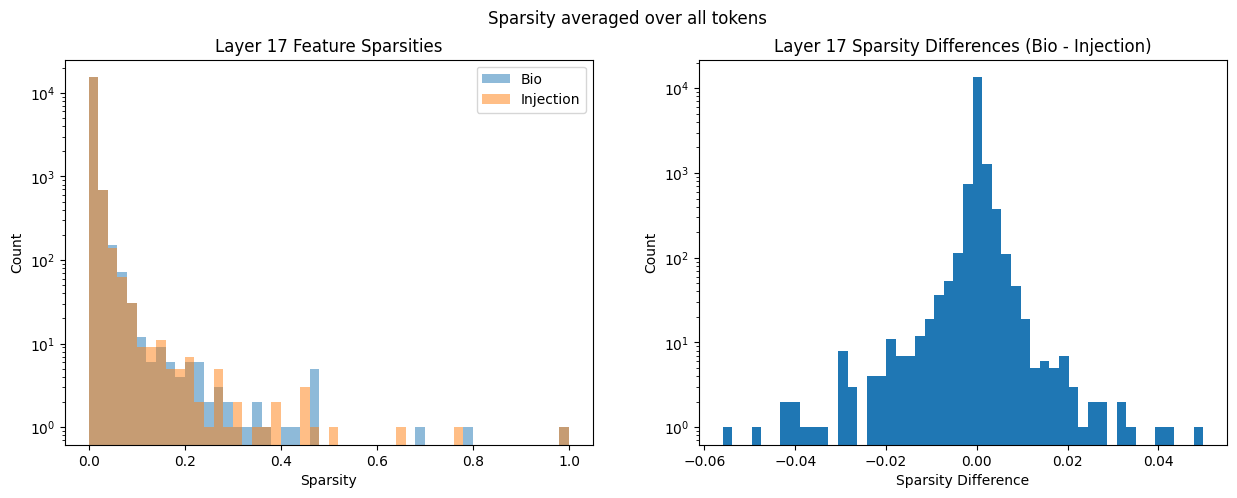

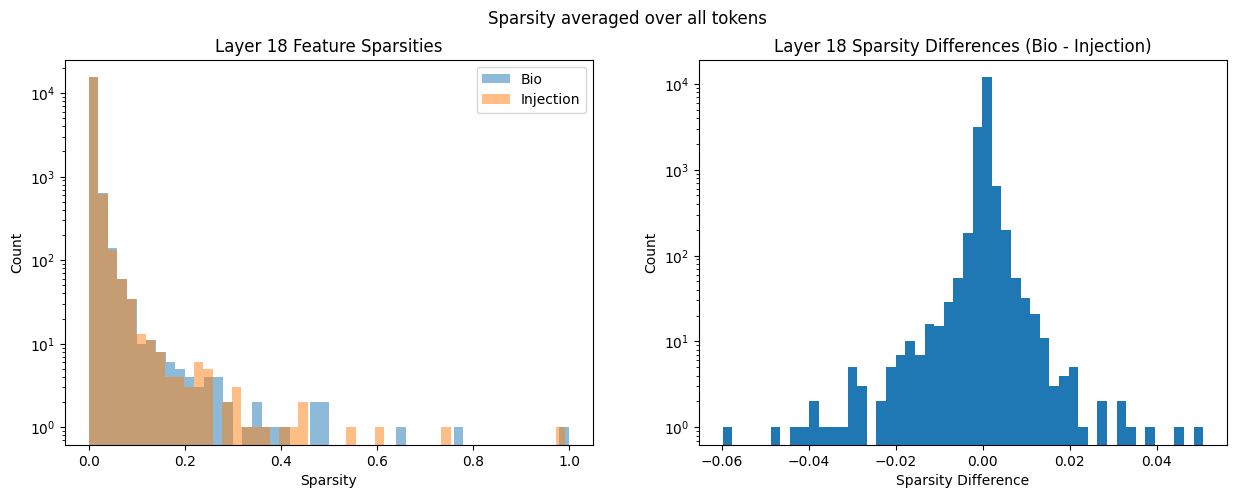

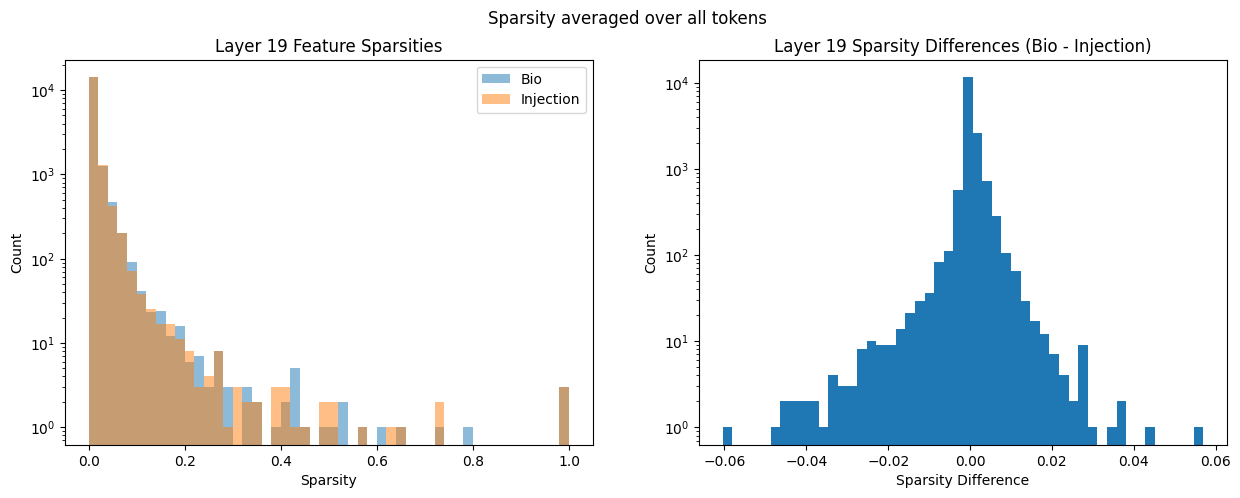

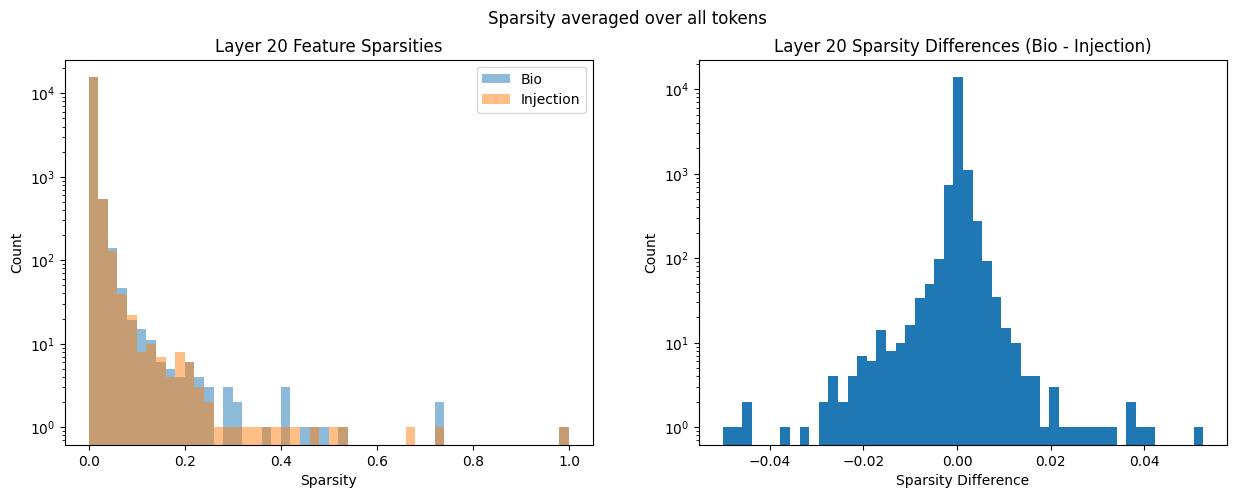

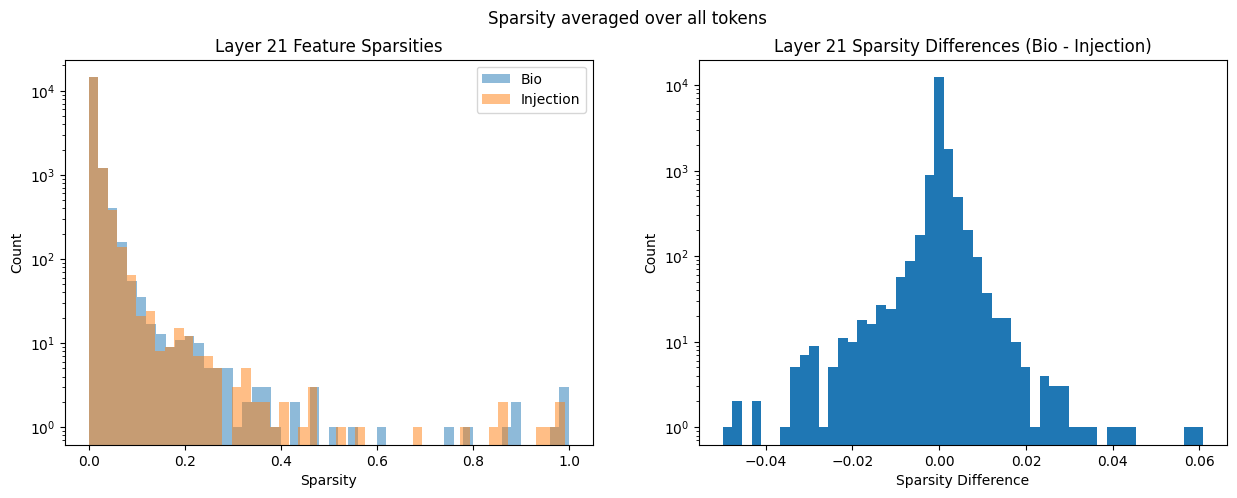

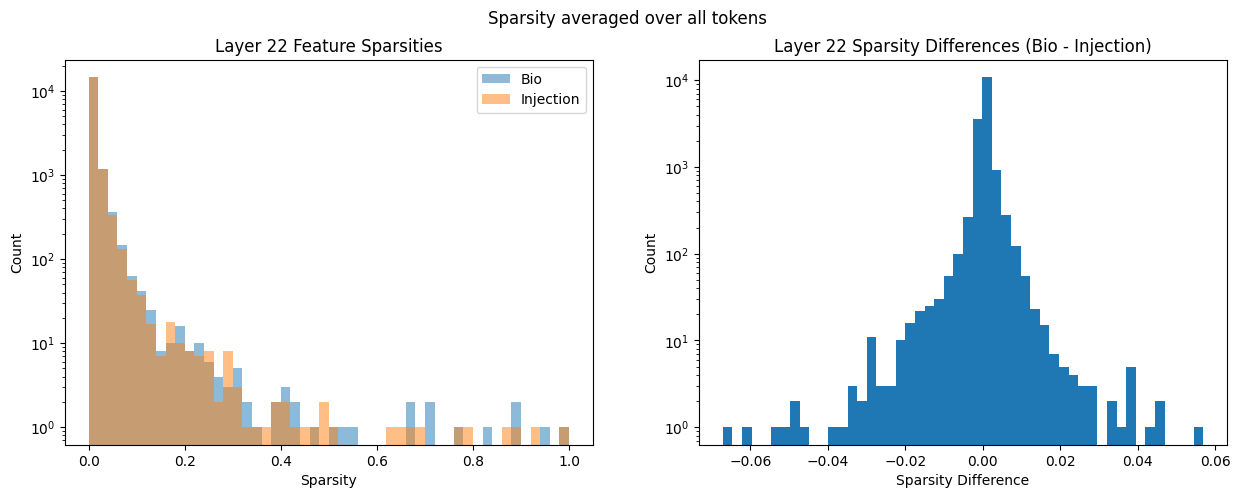

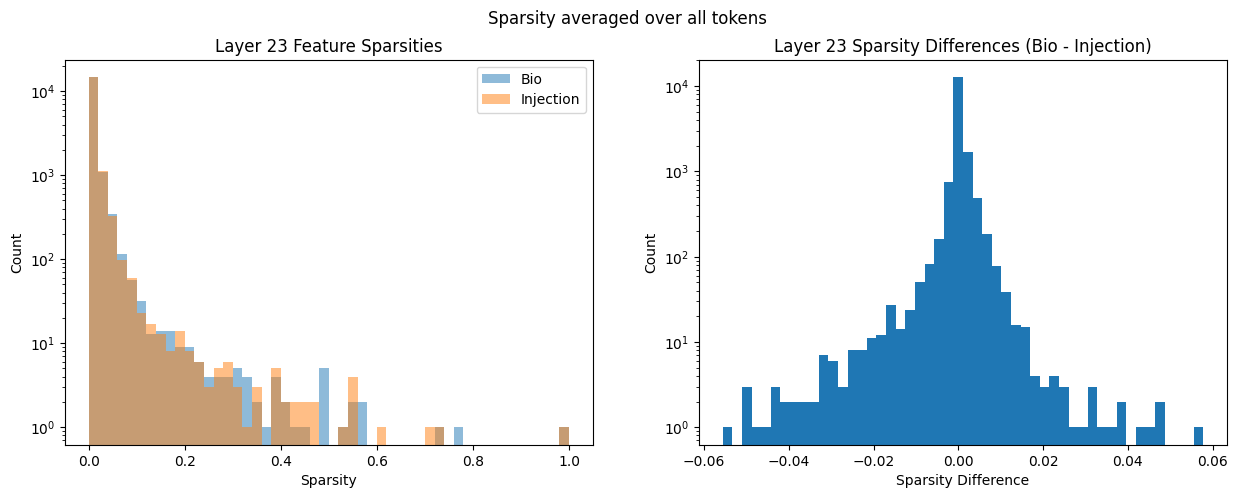

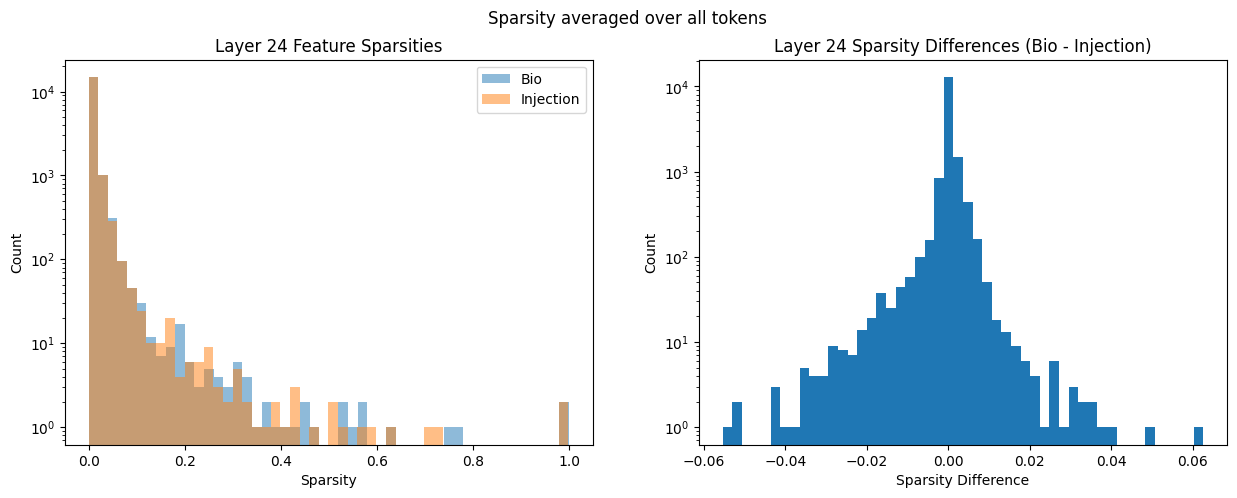

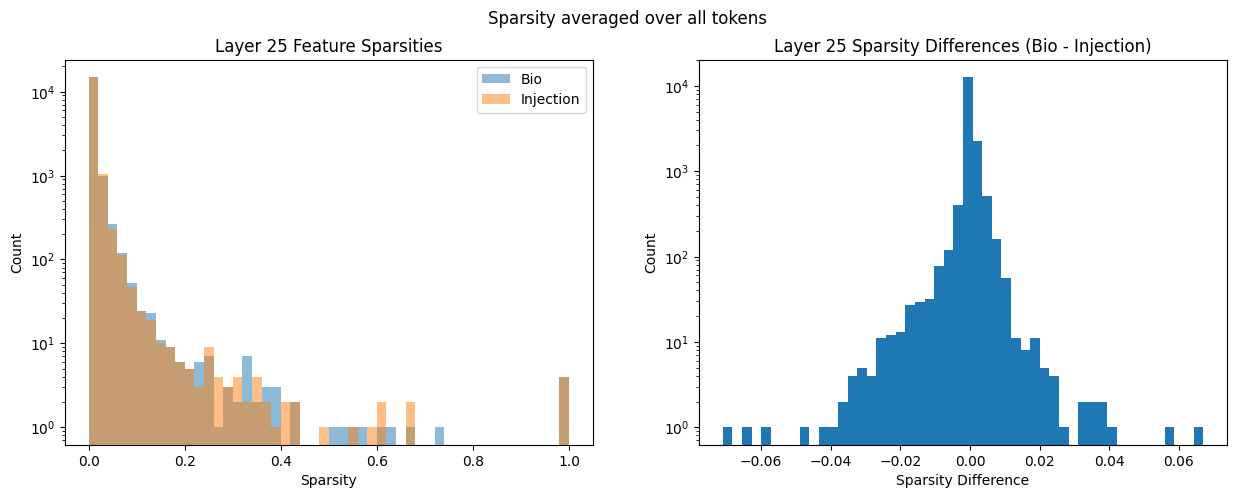

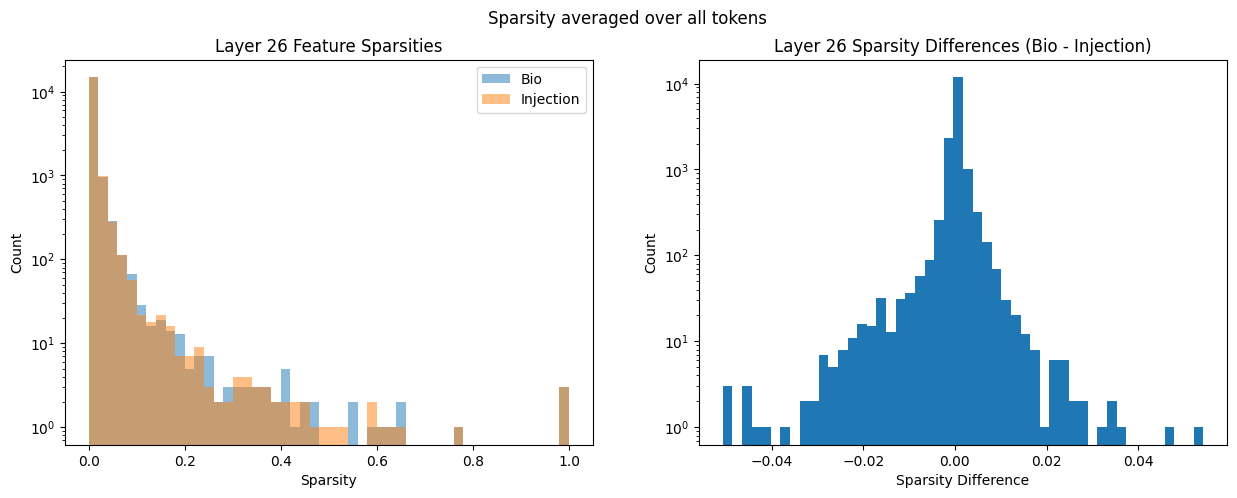

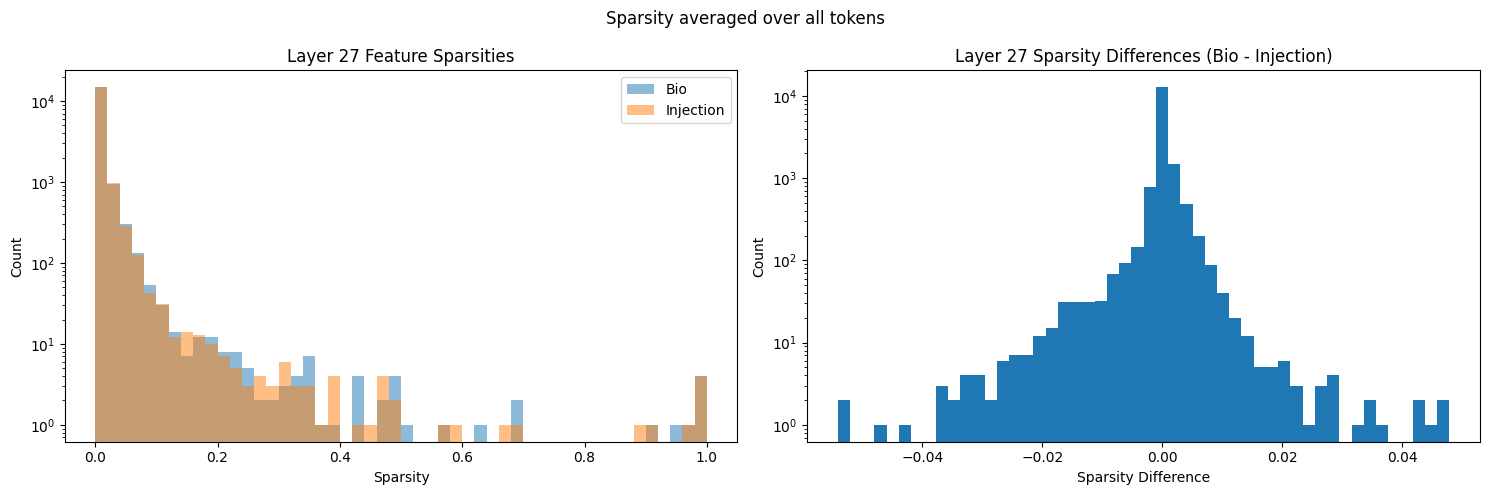

In [6]:
# plot SAE sparsities
def get_sparsity(sae_acts):
    return (sae_acts > 0).float().mean(dim=0)

for layer in sae_layers:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # Get sparsities
    bio_sparsities = get_sparsity(all_bio_sae_acts[layer]).cpu()
    injection_sparsities = get_sparsity(all_injection_sae_acts[layer]).cpu()
    
    # Plot overlapping histograms of sparsities
    ax1.hist(bio_sparsities, bins=50, alpha=0.5, label='Bio')
    ax1.hist(injection_sparsities, bins=50, alpha=0.5, label='Injection')
    ax1.set_title(f'Layer {layer} Feature Sparsities')
    ax1.set_xlabel('Sparsity')
    ax1.set_ylabel('Count')
    ax1.set_yscale('log')
    ax1.legend()
    
    # Plot histogram of differences
    sparsity_differences = bio_sparsities - injection_sparsities
    ax2.hist(sparsity_differences, bins=50, label=f'Layer {layer}')
    ax2.set_title(f'Layer {layer} Sparsity Differences (Bio - Injection)')
    ax2.set_xlabel('Sparsity Difference')
    ax2.set_ylabel('Count')
    ax2.set_yscale('log')

    plt.suptitle("Sparsity averaged over all tokens")
    # Print statistics
    print(f"\nLayer {layer} statistics:")
    print(f"Mean bio sparsity: {bio_sparsities.mean():.4f}")
    print(f"Mean injection sparsity: {injection_sparsities.mean():.4f}")
    print(f"Mean absolute difference: {sparsity_differences.abs().mean():.4f}")
    print(f"Max absolute difference: {sparsity_differences.abs().max():.4f}")

plt.tight_layout()
plt.show()

In [7]:
all_bio_sae_acts = defaultdict(list)
all_injection_sae_acts = defaultdict(list)
with torch.no_grad():
    for batch_idx in tqdm(range(num_batches)):
        bio_batch = bio_task.get_batch()
        injection_batch = injection_bio_task.get_batch()
        bio_sae_acts = get_batch_sae_acts(bio_batch, sae_layers, sae_dict, concatenate_batch_together=False)
        injection_sae_acts = get_batch_sae_acts(injection_batch, sae_layers, sae_dict, concatenate_batch_together=False)
        
        for layer in sae_layers:
            all_bio_sae_acts[layer] += bio_sae_acts[layer]
            all_injection_sae_acts[layer] += injection_sae_acts[layer]


all_max_bio_sae_acts = defaultdict(list)
all_max_injection_sae_acts = defaultdict(list)
for layer in sae_layers:
    for i in range(len(all_bio_sae_acts[layer])):
        # get maximum feature activation over all tokens
        if all_bio_sae_acts[layer][i].shape[0] == 0:
            print("Red flag: acts have 0 length, index", i)
        else:
            max_bio_acts = all_bio_sae_acts[layer][i].max(dim=0).values
            max_injection_acts = all_injection_sae_acts[layer][i].max(dim=0).values
            all_max_bio_sae_acts[layer].append(max_bio_acts)
            all_max_injection_sae_acts[layer].append(max_injection_acts)

    all_max_bio_sae_acts[layer] = torch.stack(all_max_bio_sae_acts[layer], dim=0)
    all_max_injection_sae_acts[layer] = torch.stack(all_max_injection_sae_acts[layer], dim=0)


  0%|          | 0/21 [00:00<?, ?it/s]

IndexError: max(): Expected reduction dim 0 to have non-zero size.


Layer 2 statistics:
Mean bio sparsity: 0.0578
Mean injection sparsity: 0.0491
Mean absolute difference: 0.0144
Max absolute difference: 0.2025


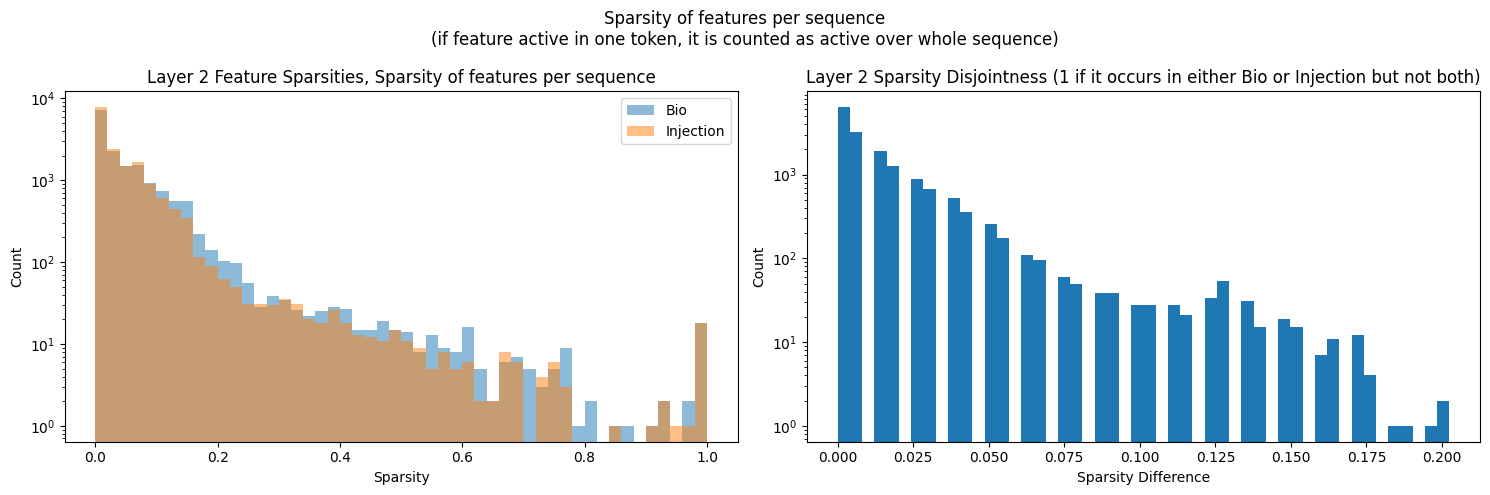


Layer 3 statistics:
Mean bio sparsity: 0.0717
Mean injection sparsity: 0.0609
Mean absolute difference: 0.0180
Max absolute difference: 0.1963


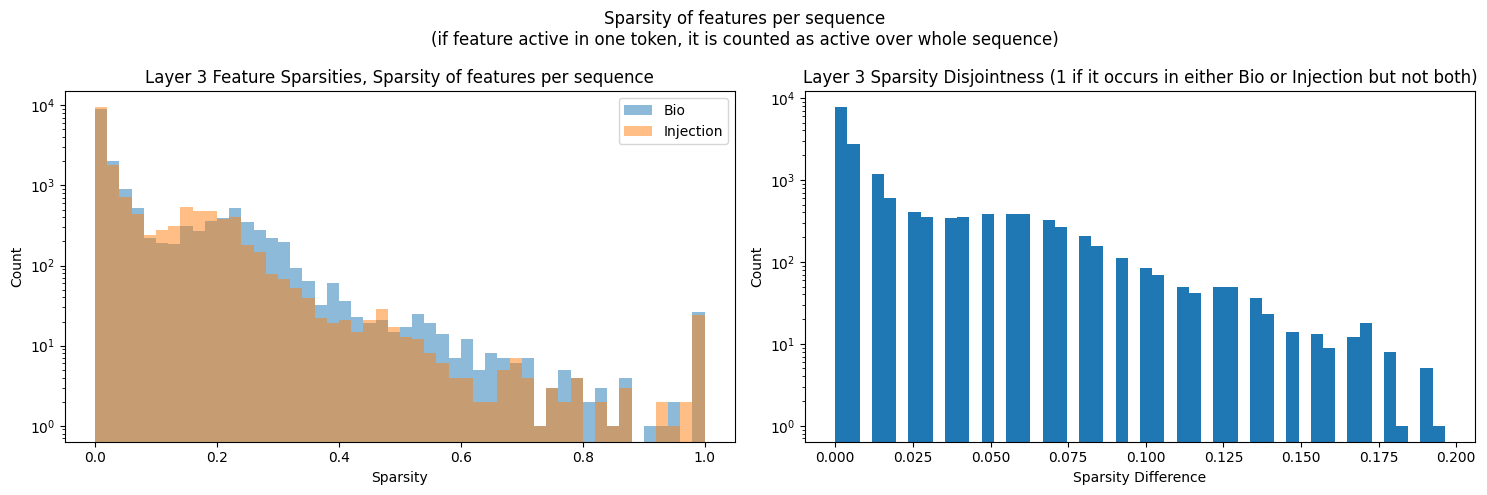


Layer 4 statistics:
Mean bio sparsity: 0.0676
Mean injection sparsity: 0.0578
Mean absolute difference: 0.0163
Max absolute difference: 0.2025


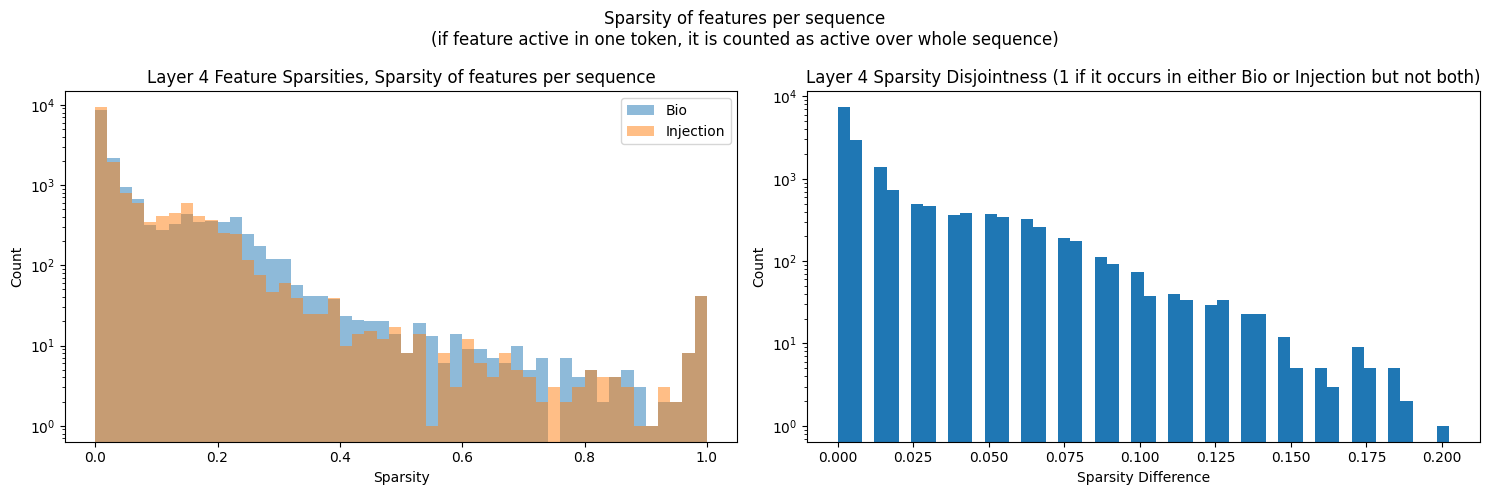


Layer 5 statistics:
Mean bio sparsity: 0.0539
Mean injection sparsity: 0.0464
Mean absolute difference: 0.0128
Max absolute difference: 0.2147


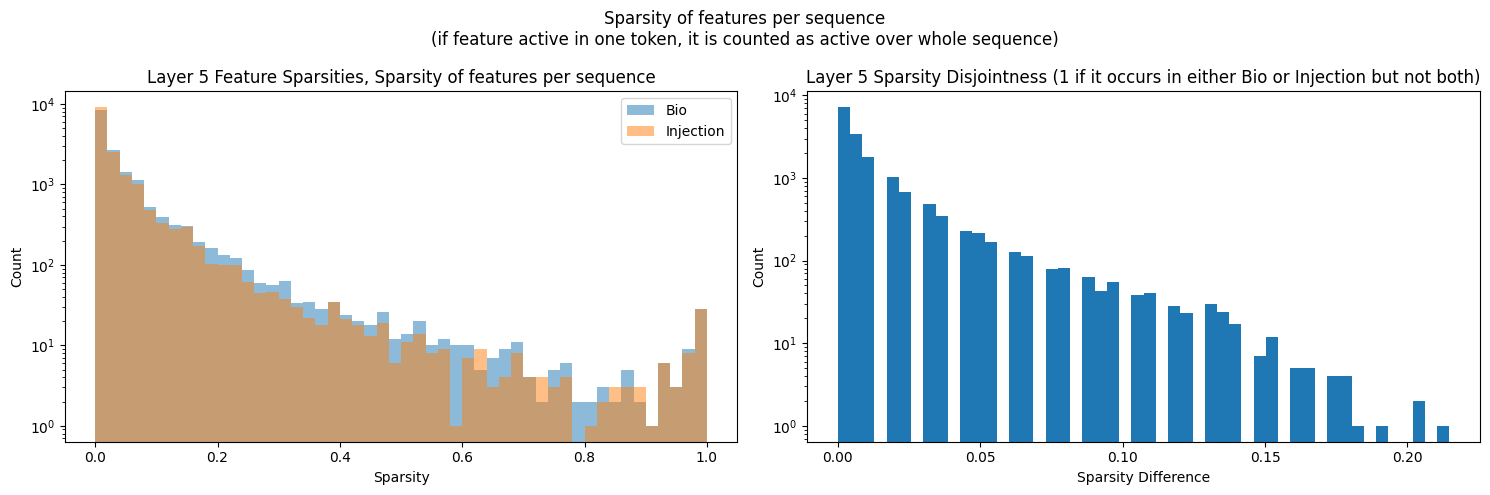


Layer 6 statistics:
Mean bio sparsity: 0.0585
Mean injection sparsity: 0.0505
Mean absolute difference: 0.0128
Max absolute difference: 0.2147


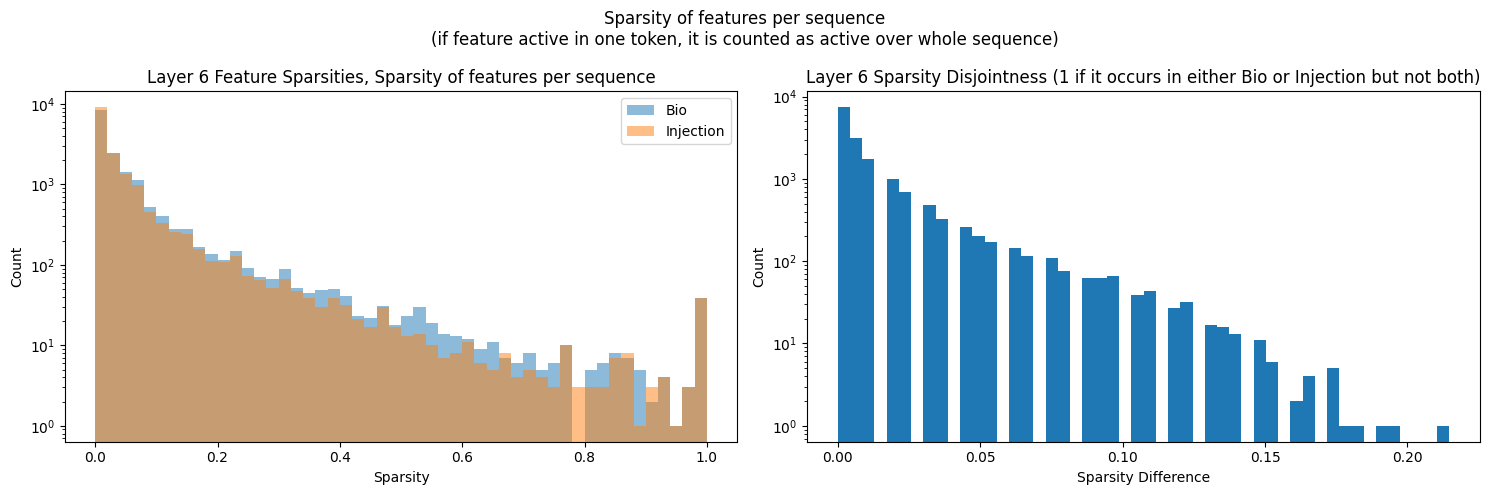


Layer 7 statistics:
Mean bio sparsity: 0.0563
Mean injection sparsity: 0.0491
Mean absolute difference: 0.0115
Max absolute difference: 0.1963


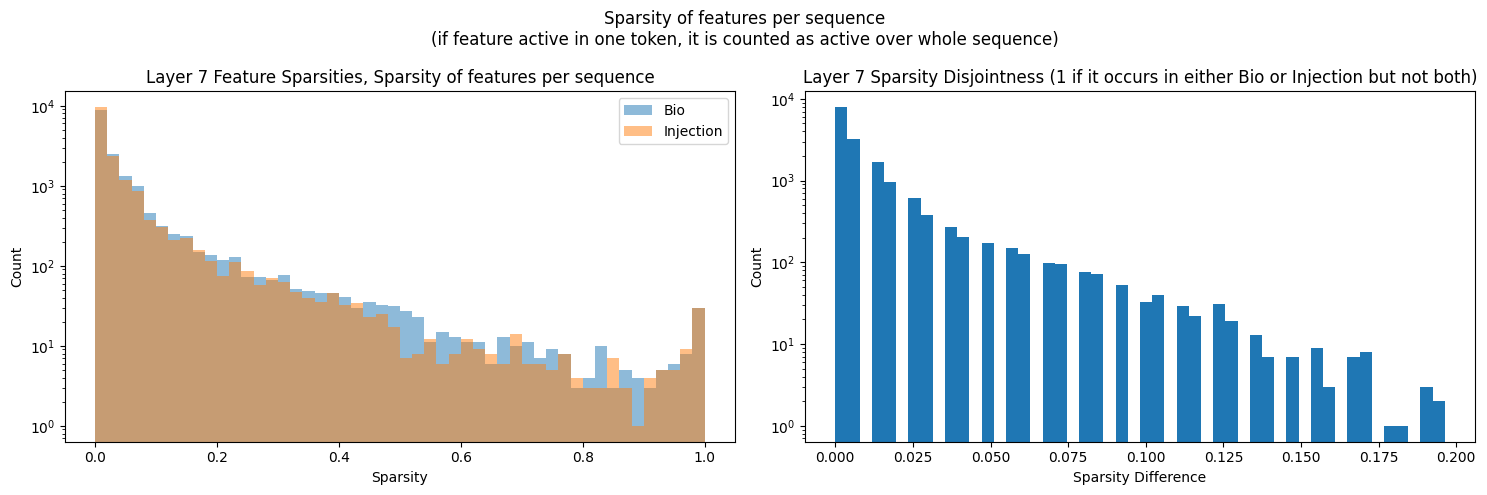


Layer 8 statistics:
Mean bio sparsity: 0.0555
Mean injection sparsity: 0.0486
Mean absolute difference: 0.0114
Max absolute difference: 0.2147


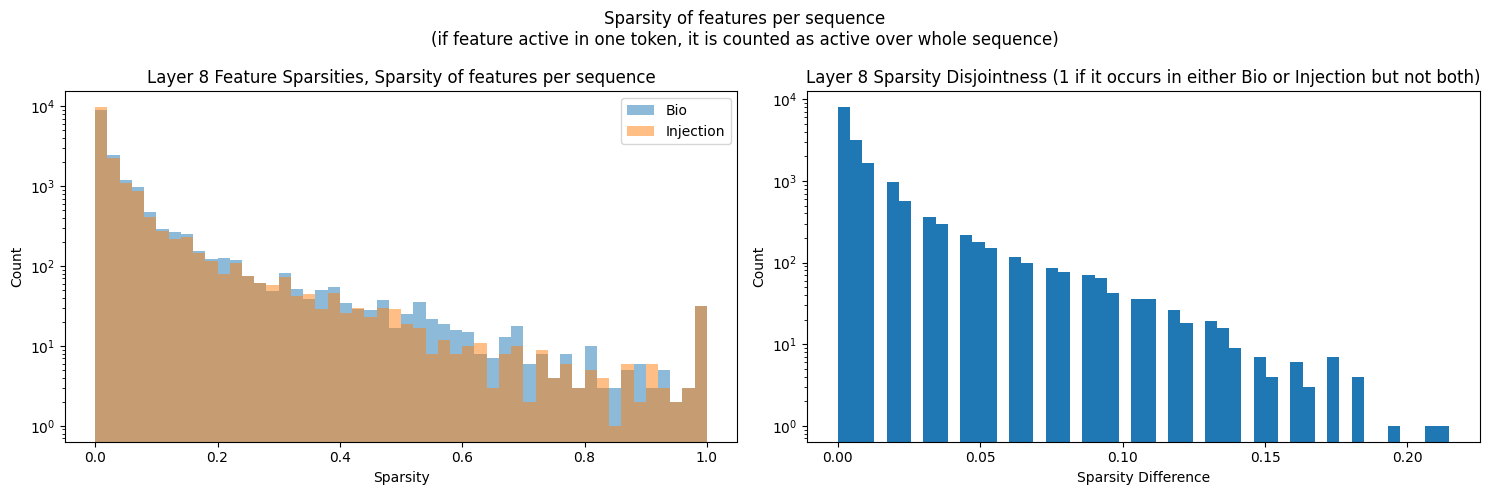


Layer 9 statistics:
Mean bio sparsity: 0.0577
Mean injection sparsity: 0.0506
Mean absolute difference: 0.0114
Max absolute difference: 0.2699


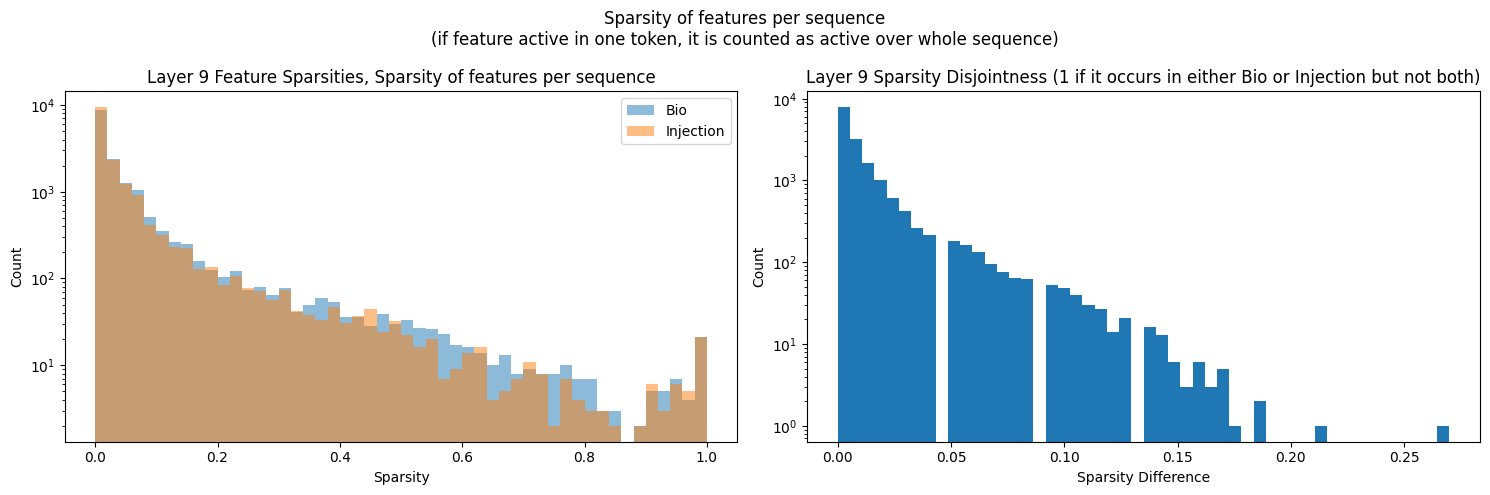


Layer 10 statistics:
Mean bio sparsity: 0.0694
Mean injection sparsity: 0.0604
Mean absolute difference: 0.0137
Max absolute difference: 0.2147


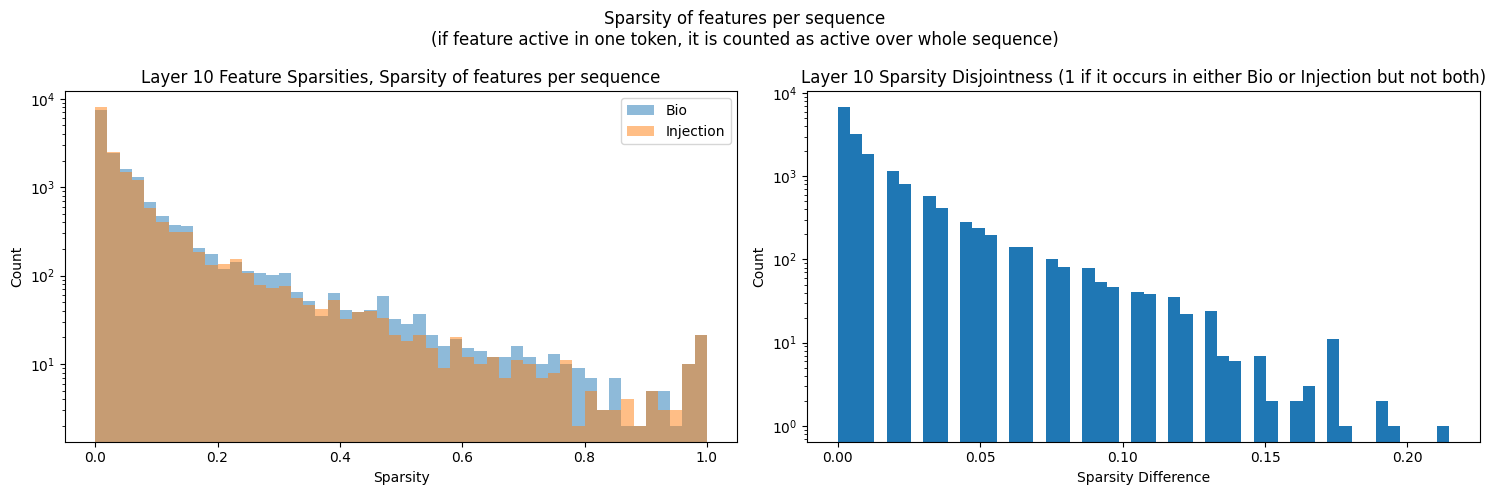


Layer 11 statistics:
Mean bio sparsity: 0.0714
Mean injection sparsity: 0.0620
Mean absolute difference: 0.0143
Max absolute difference: 0.1902


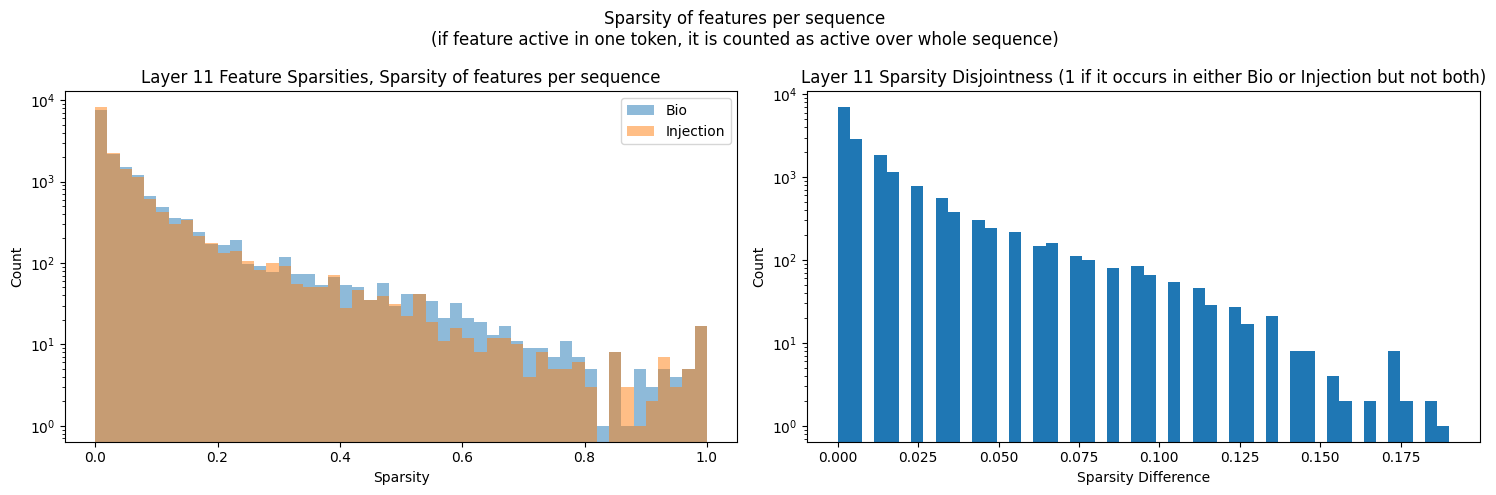


Layer 12 statistics:
Mean bio sparsity: 0.0784
Mean injection sparsity: 0.0679
Mean absolute difference: 0.0161
Max absolute difference: 0.2147


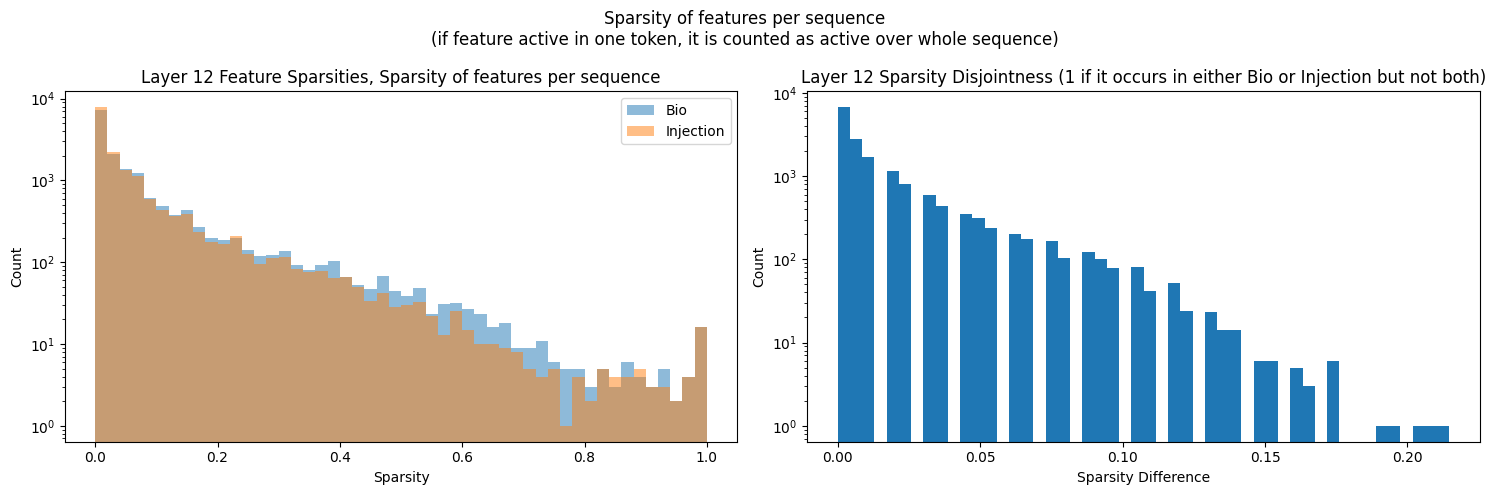


Layer 13 statistics:
Mean bio sparsity: 0.0786
Mean injection sparsity: 0.0682
Mean absolute difference: 0.0161
Max absolute difference: 0.1902


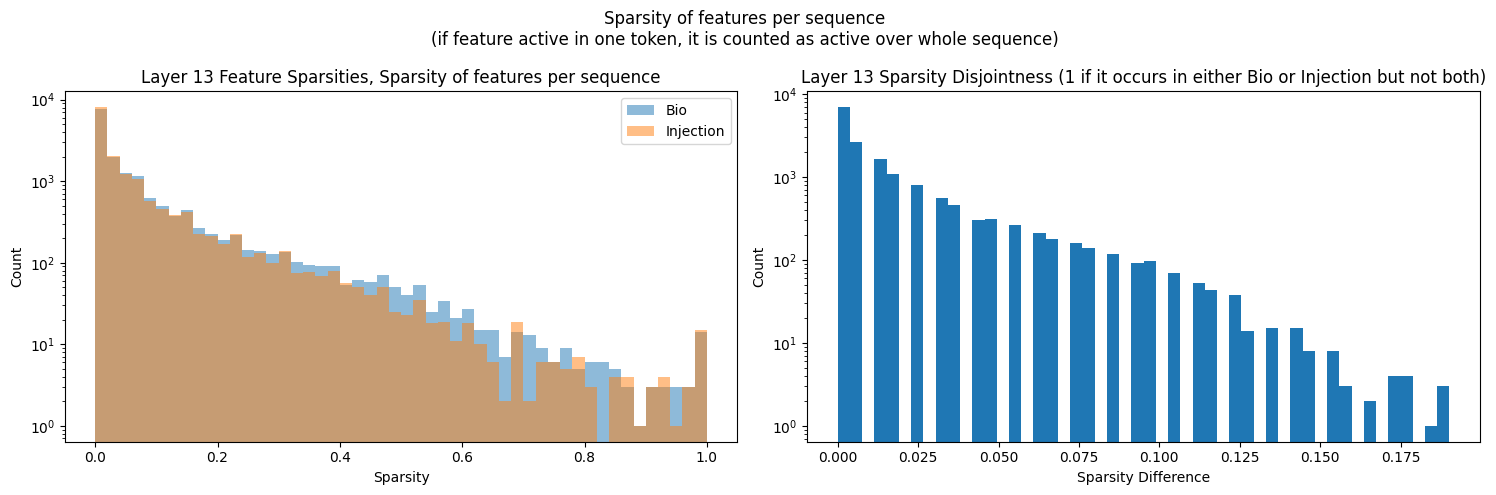


Layer 14 statistics:
Mean bio sparsity: 0.0408
Mean injection sparsity: 0.0351
Mean absolute difference: 0.0086
Max absolute difference: 0.2086


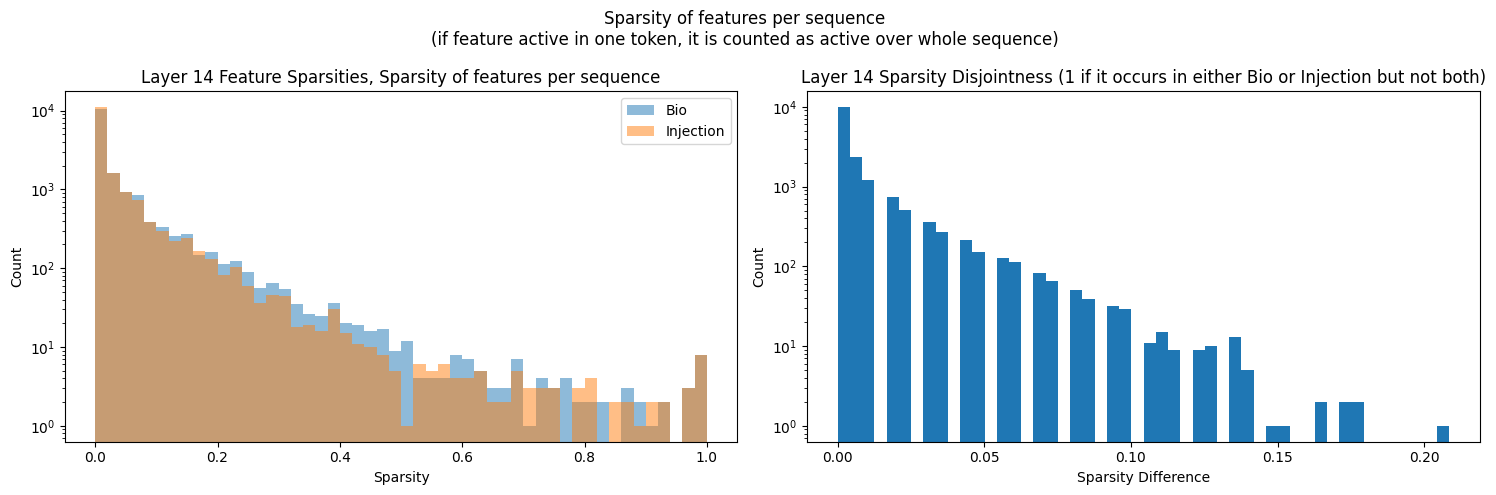


Layer 15 statistics:
Mean bio sparsity: 0.0756
Mean injection sparsity: 0.0657
Mean absolute difference: 0.0158
Max absolute difference: 0.2147


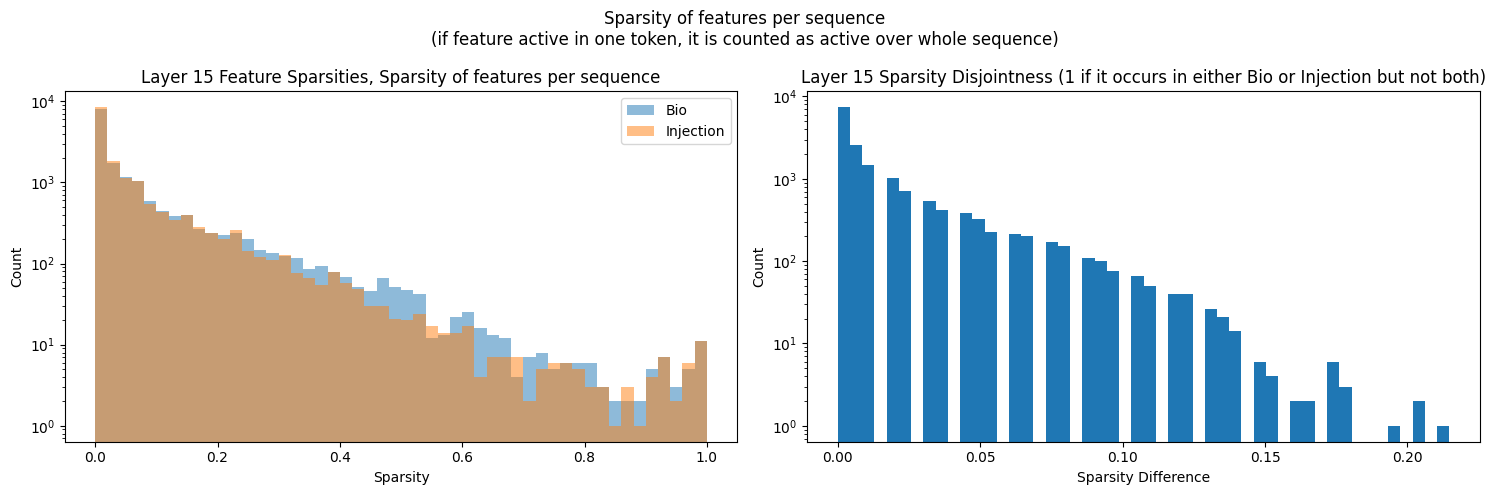


Layer 16 statistics:
Mean bio sparsity: 0.0425
Mean injection sparsity: 0.0365
Mean absolute difference: 0.0094
Max absolute difference: 0.1963


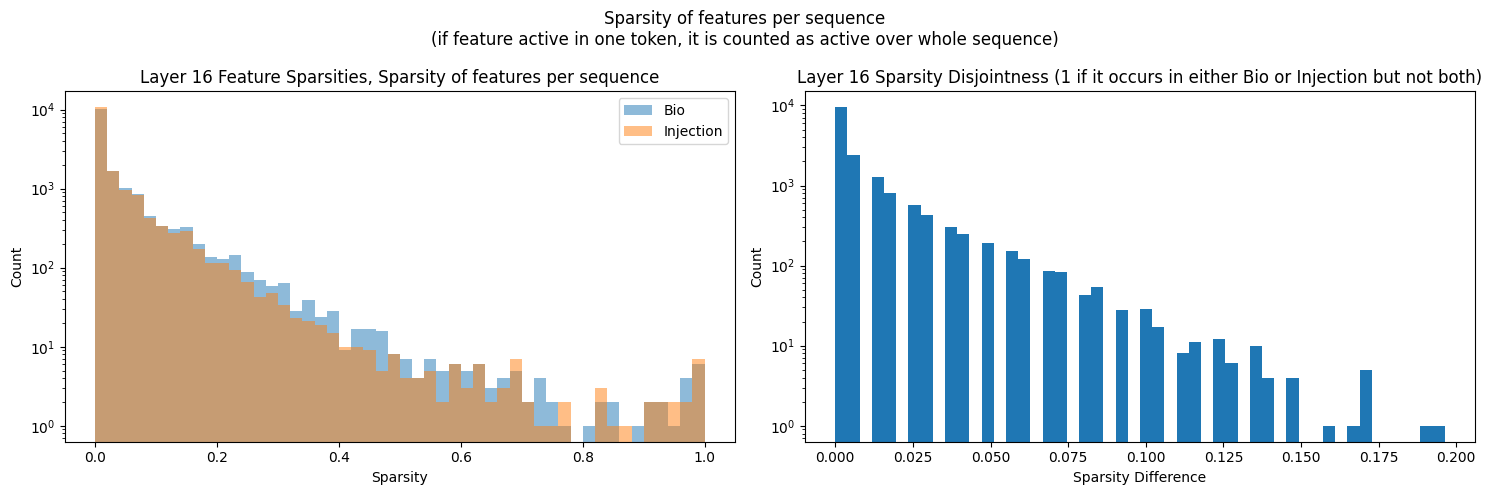


Layer 17 statistics:
Mean bio sparsity: 0.0387
Mean injection sparsity: 0.0334
Mean absolute difference: 0.0084
Max absolute difference: 0.1840


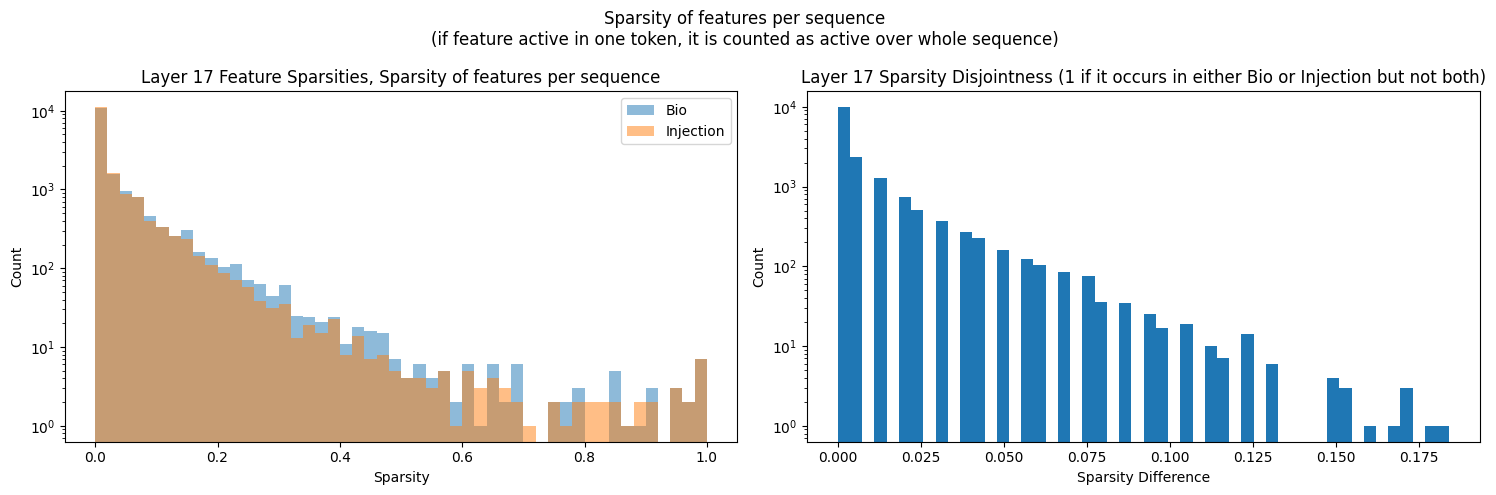


Layer 18 statistics:
Mean bio sparsity: 0.0359
Mean injection sparsity: 0.0311
Mean absolute difference: 0.0076
Max absolute difference: 0.2025


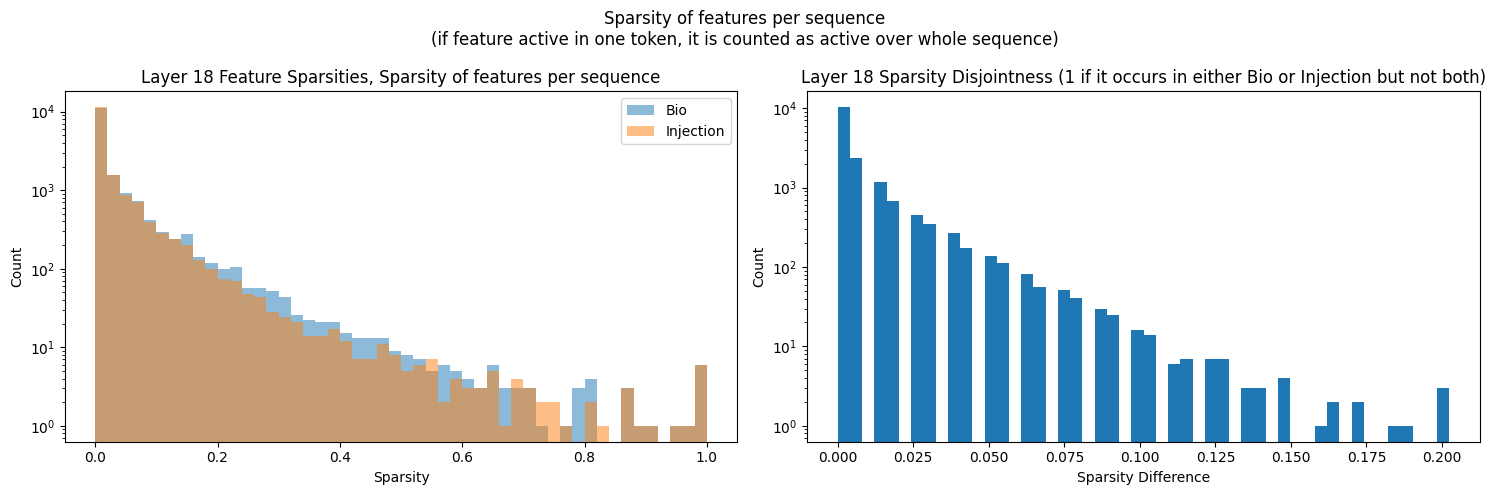


Layer 19 statistics:
Mean bio sparsity: 0.0654
Mean injection sparsity: 0.0572
Mean absolute difference: 0.0135
Max absolute difference: 0.2331


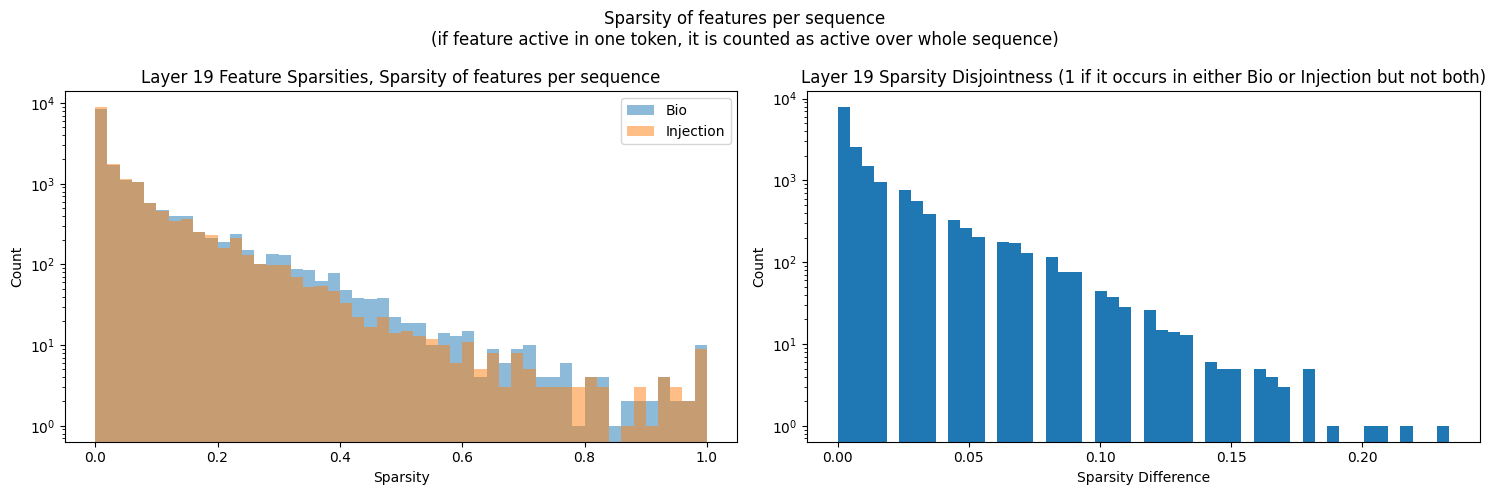


Layer 20 statistics:
Mean bio sparsity: 0.0329
Mean injection sparsity: 0.0287
Mean absolute difference: 0.0070
Max absolute difference: 0.2147


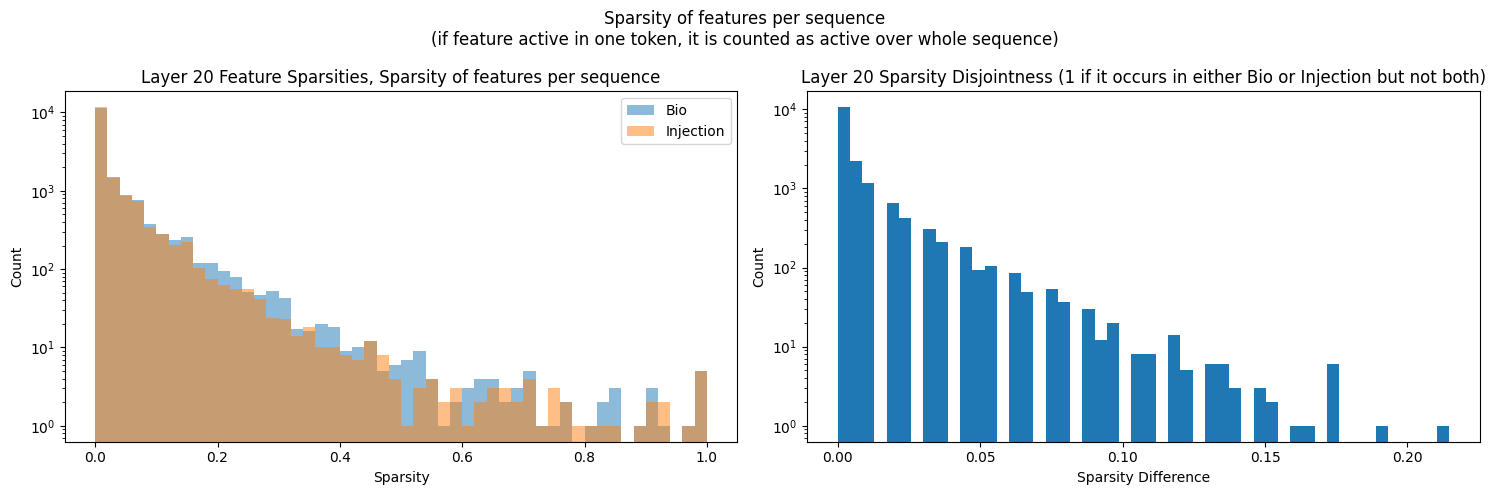


Layer 21 statistics:
Mean bio sparsity: 0.0587
Mean injection sparsity: 0.0518
Mean absolute difference: 0.0119
Max absolute difference: 0.2209


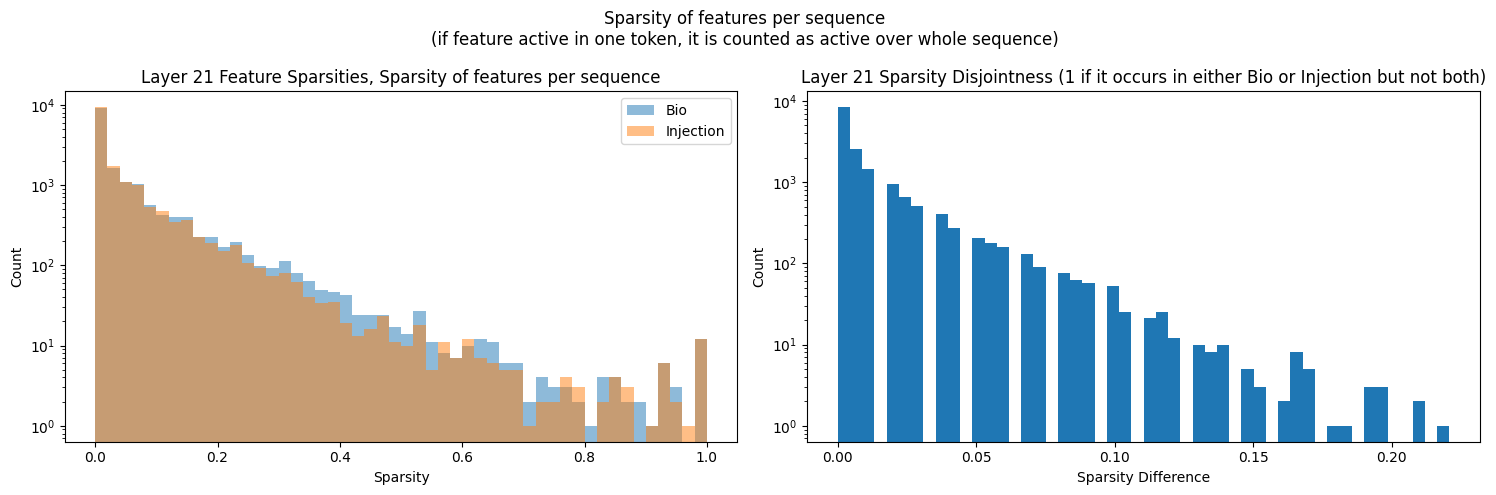


Layer 22 statistics:
Mean bio sparsity: 0.0566
Mean injection sparsity: 0.0498
Mean absolute difference: 0.0114
Max absolute difference: 0.2393


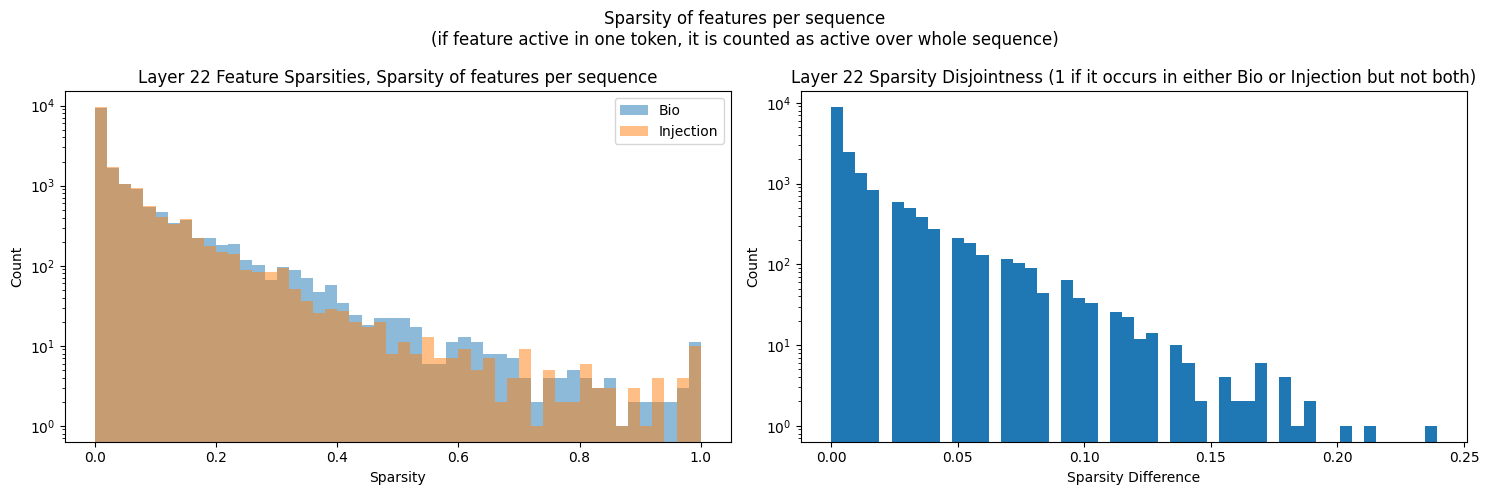


Layer 23 statistics:
Mean bio sparsity: 0.0535
Mean injection sparsity: 0.0474
Mean absolute difference: 0.0111
Max absolute difference: 0.2270


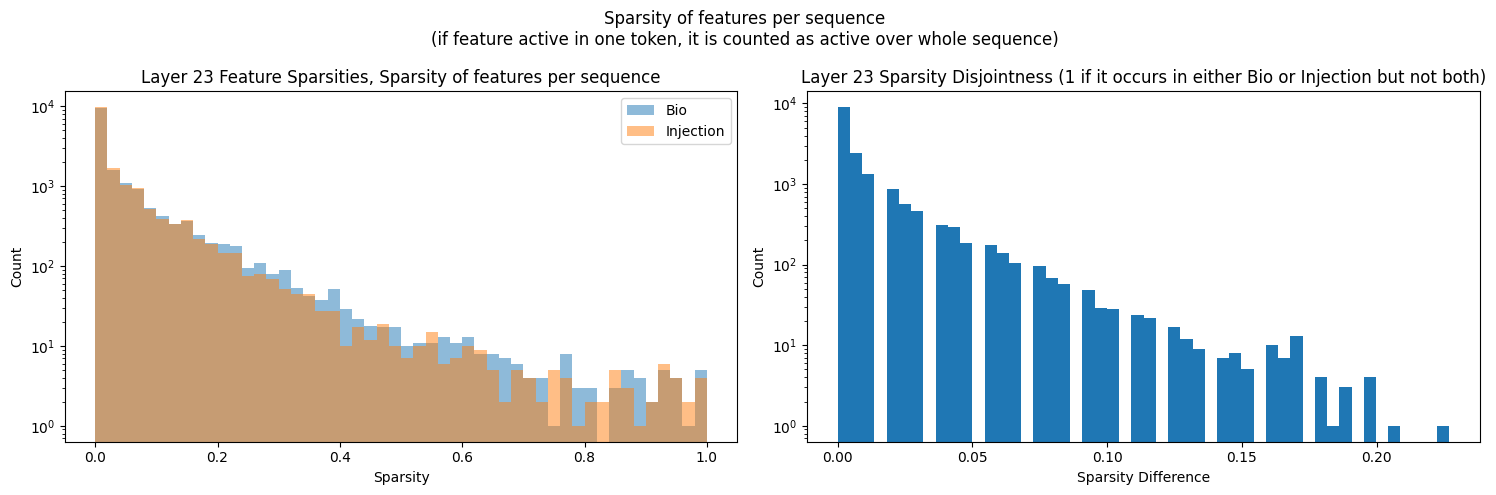


Layer 24 statistics:
Mean bio sparsity: 0.0510
Mean injection sparsity: 0.0457
Mean absolute difference: 0.0111
Max absolute difference: 0.2209


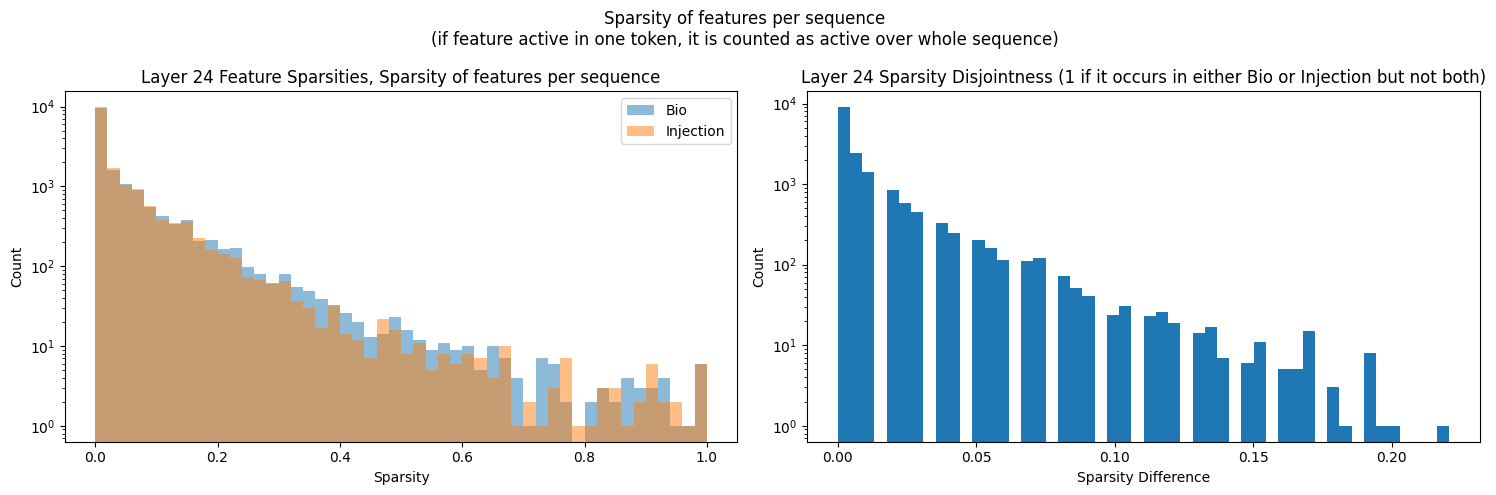


Layer 25 statistics:
Mean bio sparsity: 0.0494
Mean injection sparsity: 0.0443
Mean absolute difference: 0.0104
Max absolute difference: 0.2209


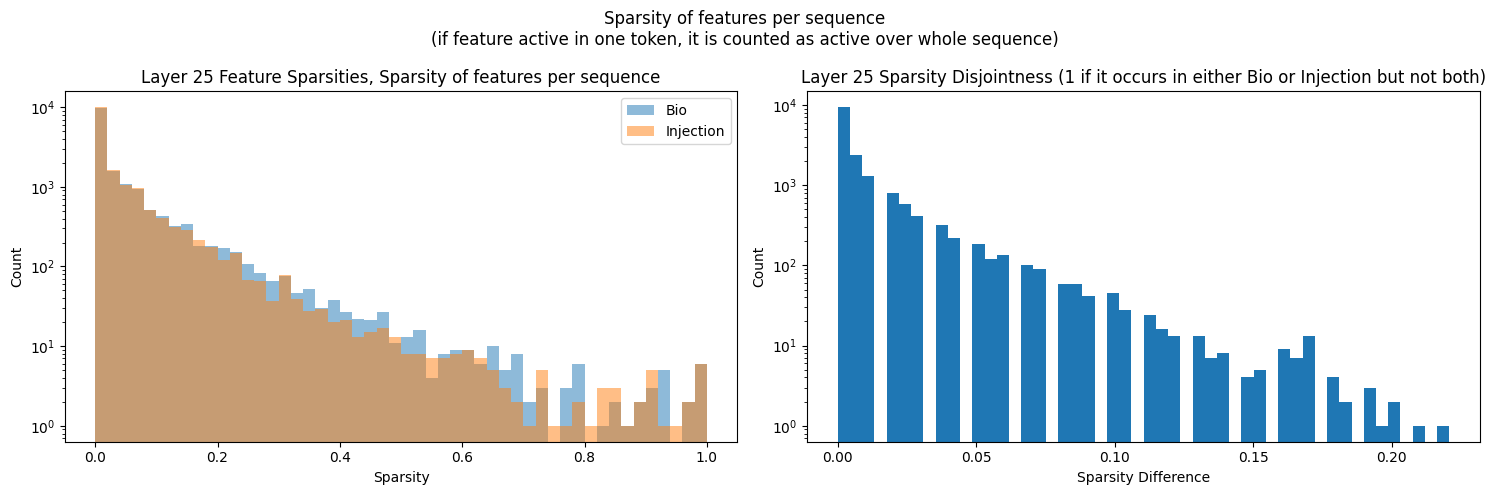


Layer 26 statistics:
Mean bio sparsity: 0.0491
Mean injection sparsity: 0.0442
Mean absolute difference: 0.0099
Max absolute difference: 0.2454


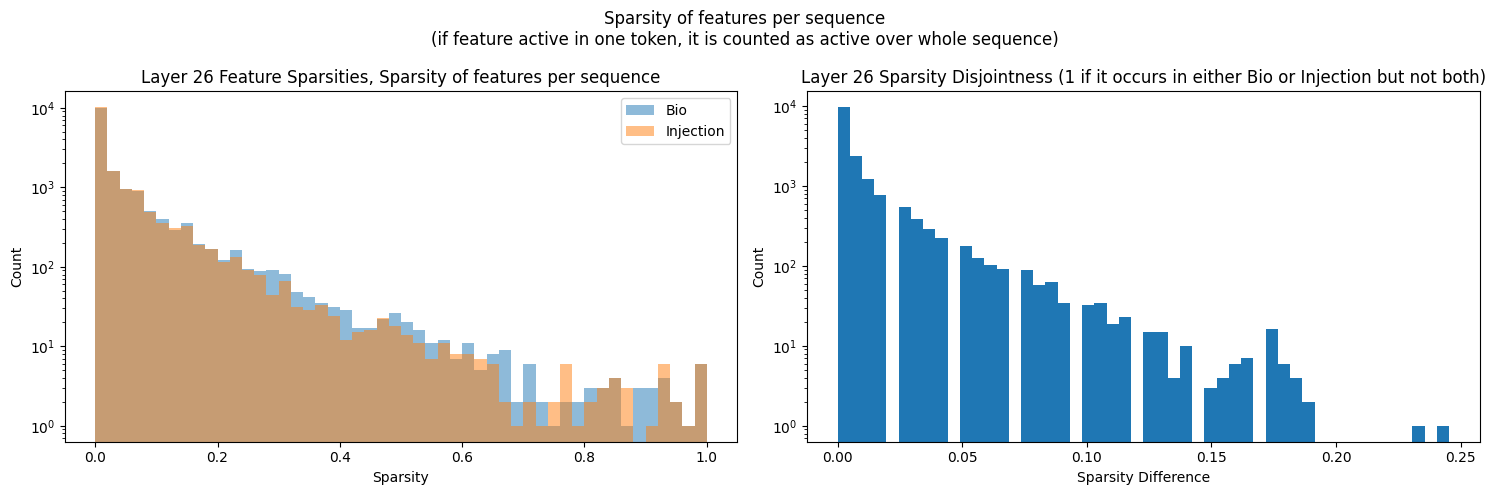


Layer 27 statistics:
Mean bio sparsity: 0.0482
Mean injection sparsity: 0.0435
Mean absolute difference: 0.0100
Max absolute difference: 0.2393


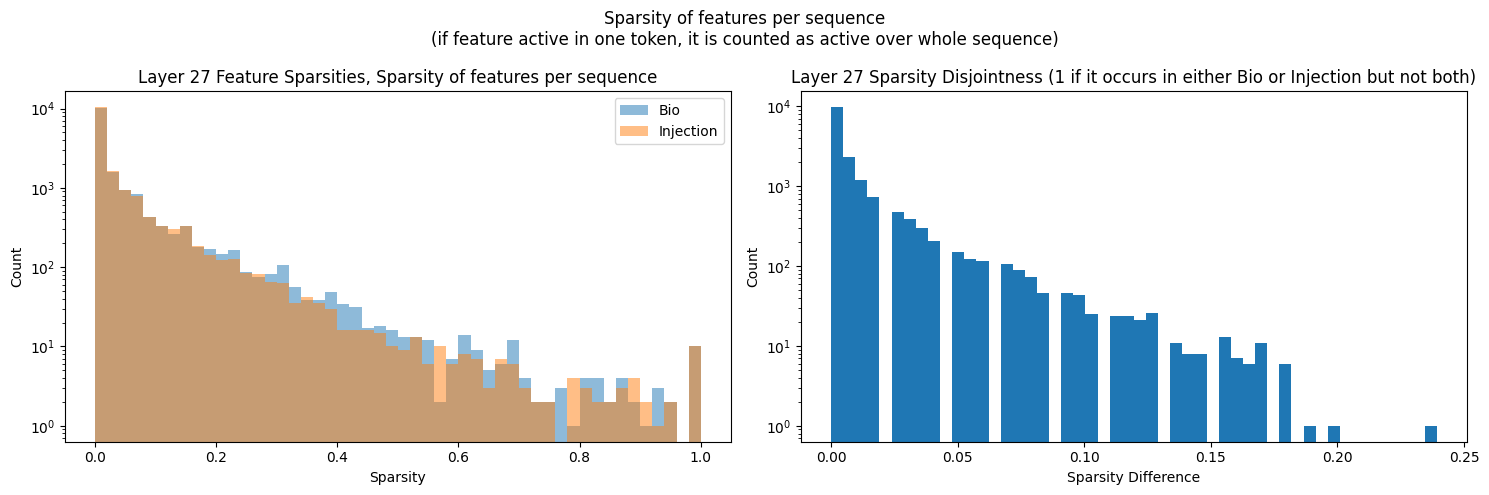

In [59]:
for layer in sae_layers:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # Get sparsities
    bio_sparsities = get_sparsity(all_max_bio_sae_acts[layer]).cpu()
    injection_sparsities = get_sparsity(all_max_injection_sae_acts[layer]).cpu()
    
    # Plot overlapping histograms of sparsities
    ax1.hist(bio_sparsities, bins=50, alpha=0.5, label='Bio')
    ax1.hist(injection_sparsities, bins=50, alpha=0.5, label='Injection')
    ax1.set_title(f'Layer {layer} Feature Sparsities, Sparsity of features per sequence')
    ax1.set_xlabel('Sparsity')
    ax1.set_ylabel('Count')
    ax1.set_yscale('log')
    ax1.legend()
    
    # Plot histogram of differences
    # sparsity_differences = bio_sparsities - injection_sparsities
    sparsity_differences = (((all_max_bio_sae_acts[layer] != 0).float() - (all_max_injection_sae_acts[layer] != 0).float()).abs().mean(dim=0)).cpu()
    ax2.hist(sparsity_differences, bins=50, label=f'Layer {layer}')
    ax2.set_title(f'Layer {layer} Sparsity Disjointness (1 if it occurs in either Bio or Injection but not both)')
    ax2.set_xlabel('Sparsity Difference')
    ax2.set_ylabel('Count')
    ax2.set_yscale('log')

    plt.suptitle("Sparsity of features per sequence\n(if feature active in one token, it is counted as active over whole sequence)")
    # Print statistics
    print(f"\nLayer {layer} statistics:")
    print(f"Mean bio sparsity: {bio_sparsities.mean():.4f}")
    print(f"Mean injection sparsity: {injection_sparsities.mean():.4f}")
    print(f"Mean absolute difference: {sparsity_differences.abs().mean():.4f}")
    print(f"Max absolute difference: {sparsity_differences.abs().max():.4f}")

    plt.tight_layout()
    plt.show()

## Semantic Interpretations of Features

In [83]:
from openai import AsyncOpenAI
import asyncio
import time
import requests

url = "https://www.neuronpedia.org/api/explanation/export"

explanation_dfs = {}
for sae_layer in tqdm(sae_layers):
    headers = {"X-Api-Key": os.getenv("NEURONPEDIA_API_KEY")}
    params = {"modelId": "gemma-2-9b", "saeId": f"{sae_layer}-gemmascope-res-16k"}
    # params = {"modelId": "gpt2-small", "saeId": "6-res-jb"}

    response = requests.get(url, headers=headers, params=params)
    print(len(response.json()))
    explanations_df = pd.DataFrame(response.json())
    explanations_df["index"] = explanations_df["index"].astype(int)
    explanations_df = explanations_df.set_index("index").sort_index()
    explanation_dfs[sae_layer] = explanations_df

  0%|          | 0/26 [00:00<?, ?it/s]

16384
16384
16381
16382
16382
16384
16382
16384
16381
16381
16381
16379
16377
16382
16378
16378
16380
16382
16378
16381
16380
16383
16383
16383
16382
16383


## Classifier on SAE Acts
Goal: figure out which SAEs are significant, so can we build an accurate linear classifier distinguishing between correct and incorrect answers using SAE activations?

In [69]:
# first, we can filter for only the SAE feature indices with absolute sparsity difference > .1
sparsity_diff_threshold = 0.15
selected_sae_features = {}
total_features = 0

correct_prompt_sae_acts = []
incorrect_prompt_sae_acts = []

selected_feature_indices = {}

total_feature_idx = 0
for layer in sae_layers:
    bio_sparsities = get_sparsity(all_max_bio_sae_acts[layer]).cpu()
    injection_sparsities = get_sparsity(all_max_injection_sae_acts[layer]).cpu()
    # abs_sparsity_diff = (bio_sparsities - injection_sparsities).abs()
    sparsity_differences = (((all_max_bio_sae_acts[layer] != 0).float() - (all_max_injection_sae_acts[layer] != 0).float()).abs().mean(dim=0)).cpu()
    selected_sae_features[layer] = (sparsity_differences > sparsity_diff_threshold).nonzero().squeeze()

    for selected_feature_idx in selected_sae_features[layer]:
        selected_feature_indices[total_feature_idx] = (layer, selected_feature_idx)
        total_feature_idx += 1
    total_features += len(selected_sae_features[layer])

    correct_prompt_sae_acts.append(all_max_bio_sae_acts[layer][:, selected_sae_features[layer]] > 0)
    incorrect_prompt_sae_acts.append(all_max_injection_sae_acts[layer][:, selected_sae_features[layer]] > 0)

correct_prompt_sae_acts = torch.cat(correct_prompt_sae_acts, dim=1).float()
incorrect_prompt_sae_acts = torch.cat(incorrect_prompt_sae_acts, dim=1).float()

In [70]:
correct_prompt_sae_acts.shape

torch.Size([163, 781])

In [71]:
num_train_indices = int(correct_prompt_sae_acts.shape[0] * 0.6)
num_val_indices = int(correct_prompt_sae_acts.shape[0] * 0.2)
num_test_indices = int(correct_prompt_sae_acts.shape[0] * 0.2)

train_correct_sae_acts = correct_prompt_sae_acts[:num_train_indices]
train_incorrect_sae_acts = incorrect_prompt_sae_acts[:num_train_indices]
val_correct_sae_acts = correct_prompt_sae_acts[num_train_indices:num_train_indices+num_val_indices]
val_incorrect_sae_acts = incorrect_prompt_sae_acts[num_train_indices:num_train_indices+num_val_indices]
test_correct_sae_acts = correct_prompt_sae_acts[num_train_indices+num_val_indices:]
test_incorrect_sae_acts = incorrect_prompt_sae_acts[num_train_indices+num_val_indices:]


In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Combine correct and incorrect samples and create labels
X_train = torch.cat([train_correct_sae_acts, train_incorrect_sae_acts], dim=0).cpu().numpy()
y_train = np.concatenate([np.ones(len(train_correct_sae_acts)), np.zeros(len(train_incorrect_sae_acts))])

X_val = torch.cat([val_correct_sae_acts, val_incorrect_sae_acts], dim=0).cpu().numpy()
y_val = np.concatenate([np.ones(len(val_correct_sae_acts)), np.zeros(len(val_incorrect_sae_acts))])

X_test = torch.cat([test_correct_sae_acts, test_incorrect_sae_acts], dim=0).cpu().numpy()
y_test = np.concatenate([np.ones(len(test_correct_sae_acts)), np.zeros(len(test_incorrect_sae_acts))])

# Train Lasso logistic regression
# C is the inverse of regularization strength - smaller values mean stronger regularization
# L1 (Lasso) regularization
clf_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.5)
# L2 (Ridge) regularization 
clf_l2 = LogisticRegression(penalty='l2', solver='lbfgs', C=0.1)
clf = clf_l1  # Use Lasso as default for rest of code
# clf = LogisticRegression()
clf.fit(X_train, y_train)

# Get predictions and accuracies
train_preds = clf.predict(X_train)
val_preds = clf.predict(X_val)
test_preds = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, train_preds)
val_accuracy = accuracy_score(y_val, val_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Train accuracy: {train_accuracy:.3f}")
print(f"Validation accuracy: {val_accuracy:.3f}")
# print(f"Test accuracy: {test_accuracy:.3f}")

# Print number of features used (non-zero coefficients)
n_features_used = np.sum(clf.coef_ != 0)
print(f"\nNumber of features used: {n_features_used} out of {X_train.shape[1]}")

Train accuracy: 0.840
Validation accuracy: 0.641

Number of features used: 51 out of 781


In [93]:
for feature_idx in np.where(clf.coef_ != 0)[1]:
    sae_layer, sae_feature_idx = selected_feature_indices[feature_idx]
    print(f"Feature {feature_idx} from layer {sae_layer} with index {sae_feature_idx} is used in the classifier, explanation: {explanation_dfs[sae_layer].loc[sae_feature_idx.item(), 'description']}")


Feature 3 from layer 2 with index 827 is used in the classifier, explanation: references to authority and hierarchical structures
Feature 4 from layer 2 with index 1341 is used in the classifier, explanation: references to time and action in a technical context
Feature 47 from layer 2 with index 15037 is used in the classifier, explanation: elements related to programming constructs and structures, particularly in JSON and XML serialization and data management
Feature 56 from layer 3 with index 436 is used in the classifier, explanation: references to top-rated actors and films, along with programming terms and constructs related to web API development
Feature 58 from layer 3 with index 1630 is used in the classifier, explanation: specific terms related to testing configurations and results within software or systems
Feature 66 from layer 3 with index 3809 is used in the classifier, explanation:  key structural or functional components related to programming or data processing
Feature 

In [78]:
clf.coef_

array([[ 4.99369433e-02, -1.68606762e-02, -1.72649441e-02,
         2.69961784e-01, -6.66029175e-02, -4.41618656e-03,
        -6.10084805e-02, -3.03506662e-02,  1.28540880e-02,
        -1.38366001e-02, -5.70230291e-02, -4.62169761e-03,
         4.85205312e-03,  6.52697071e-03,  5.12813713e-02,
        -3.43456438e-02,  2.52485066e-02, -5.78875294e-02,
        -1.93015626e-02, -1.86088087e-02, -1.86088087e-02,
         7.25049293e-02, -3.98580873e-02, -1.86088087e-02,
         2.62927870e-02, -4.11591955e-03,  9.59270003e-02,
        -7.91625998e-03,  1.43150240e-04, -7.68289676e-02,
        -6.82910609e-02,  3.44585463e-02, -7.36559850e-02,
        -2.78733039e-02,  4.45365557e-02, -1.86088087e-02,
         1.19781998e-02, -2.64127701e-03, -9.89583179e-02,
        -5.90169976e-02, -1.86088087e-02,  1.03798594e-02,
        -9.43122046e-02, -5.55320755e-03, -7.81179049e-02,
        -9.80475508e-03,  1.08201929e-02, -1.33850107e-01,
        -2.89411880e-02, -9.41897537e-02, -7.49913516e-0

  0%|          | 0/20 [00:00<?, ?it/s]

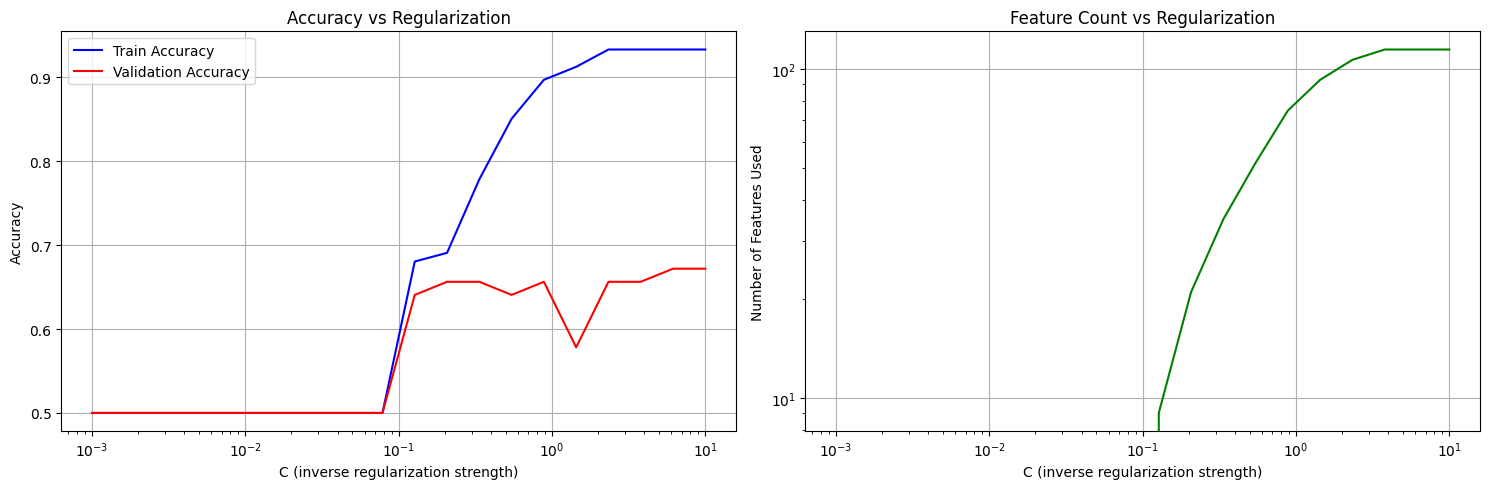

Best validation accuracy: 0.672
Best C value: 6.158e+00
Number of features at best C: 115
Train accuracy at best C: 0.933


In [73]:
# Test different C values on a log scale
C_values = np.logspace(-3, 1, 20)  # Creates 20 points from 10^-3 to 10^1
train_accuracies = []
val_accuracies = []
# test_accuracies = []
n_features = []

for C in tqdm(C_values):
    clf = LogisticRegression(penalty='l1', solver='liblinear', C=C)
    clf.fit(X_train, y_train)
    
    # Get accuracies
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    val_acc = accuracy_score(y_val, clf.predict(X_val))
    # test_acc = accuracy_score(y_test, clf.predict(X_test))
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    # test_accuracies.append(test_acc)
    n_features.append(np.sum(clf.coef_ != 0))

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracies
ax1.semilogx(C_values, train_accuracies, 'b-', label='Train Accuracy')
ax1.semilogx(C_values, val_accuracies, 'r-', label='Validation Accuracy')
ax1.set_xlabel('C (inverse regularization strength)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Regularization')
ax1.grid(True)
ax1.legend()

# Plot number of features
ax2.semilogx(C_values, n_features, 'g-')
ax2.set_xlabel('C (inverse regularization strength)')
ax2.set_ylabel('Number of Features Used')
ax2.set_title('Feature Count vs Regularization')
ax2.set_yscale('log')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print best test accuracy and corresponding C value
best_idx = np.argmax(val_accuracies)
print(f"Best validation accuracy: {val_accuracies[best_idx]:.3f}")
print(f"Best C value: {C_values[best_idx]:.3e}")
print(f"Number of features at best C: {n_features[best_idx]}")
print(f"Train accuracy at best C: {train_accuracies[best_idx]:.3f}")

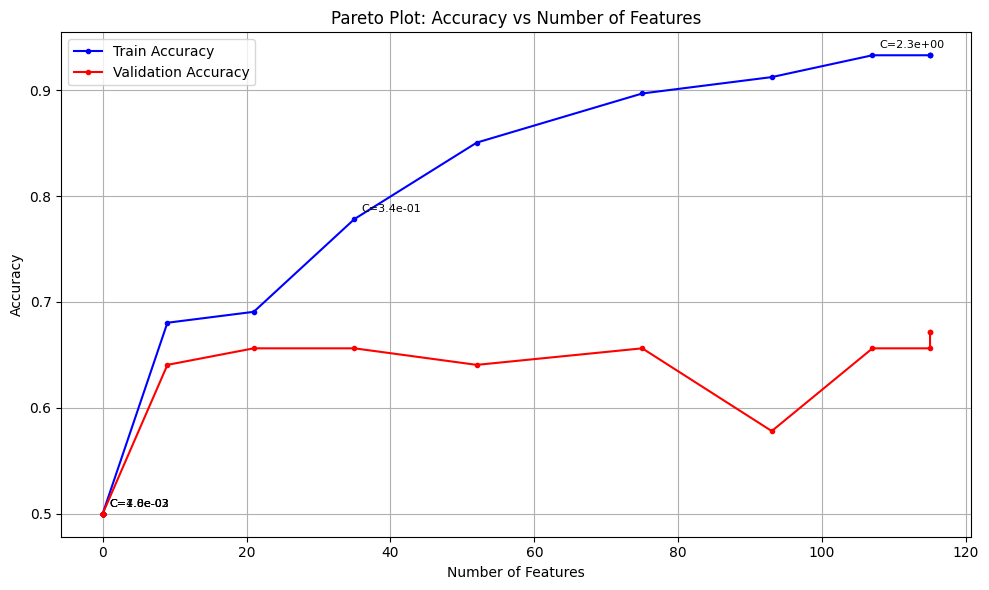

In [74]:
# Create Pareto plot
plt.figure(figsize=(10, 6))

# Sort points by number of features to create Pareto frontier
pareto_points = list(zip(n_features, train_accuracies))
pareto_points.sort()  # Sort by number of features

# Plot points
plt.plot([p[0] for p in pareto_points], 
         [p[1] for p in pareto_points], 
         'b.-', label='Train Accuracy')

# Add test accuracy points
val_points = list(zip(n_features, val_accuracies))
val_points.sort()  # Sort by number of features
plt.plot([p[0] for p in val_points], 
         [p[1] for p in val_points], 
         'r.-', label='Validation Accuracy')

plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Pareto Plot: Accuracy vs Number of Features')
# plt.xscale('log')
plt.grid(True)
plt.legend()

# Annotate some points with their C values
for i, (n_feat, train_acc, test_acc, C) in enumerate(zip(n_features, train_accuracies, val_accuracies, C_values)):
    if i % 4 == 0:  # Annotate every 4th point to avoid clutter
        plt.annotate(f'C={C:.1e}', 
                    (n_feat, train_acc),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=8)

plt.tight_layout()
plt.show()

## Test Causal Relationship

In [ ]:
def clamp_sae_feature(act, sae, features, clamp_value=0):
    if isinstance(features, int):
        features = [features]
    feature_w = sae.W_enc[:, features] # [hidden, n_features]
    feature_b = sae.b_enc[features] # [n_features]
    threshold = sae.threshold[features] # [n_features]
    feature_vec = sae.W_dec[features] # [n_features, hidden]

    # print(f"{feature_w.shape=}, {feature_b.shape=}, {threshold.shape=}, {feature_vec.shape=}, {act.shape=}")

    with torch.amp.autocast(device_type="cuda", dtype=dtype):
        feature_acts = einops.einsum(act, feature_w, "... hidden, hidden n_features -> ... n_features") + feature_b
        # print(f"{feature_acts.shape=}")
        # feature_acts = (feature_acts > threshold) * feature_acts
        clamped_feature_diff = torch.where(feature_acts > threshold, clamp_value - feature_acts, 0)
        # print(f"{clamped_feature_diff.shape=}")
    # if feature act is 0, then don't need to do anything
    # if feature act is positive, then need to clamp it: can replicate by subtracting (feature_acts - clamp_value) * feature_w_dec
        output = act + einops.einsum(clamped_feature_diff, feature_vec, "... n_features, n_features hidden -> ... hidden")
    return output

def clamp_sae_feature_decode(act, sae, features, clamp_value=0):
    sae_acts = sae.encode(act)
    if isinstance(features, int):
        features = [features]
    # print(f"{sae_acts.shape=}")
    # print(f"{sae_acts[..., features]=}")
    with torch.amp.autocast(device_type="cuda", dtype=dtype):
        feature_clamped_acts = torch.where(sae_acts[..., features] > 0, clamp_value, 0.)
        sae_acts[..., features] = feature_clamped_acts
        output = sae.decode(sae_acts).to(dtype)
    return output

def get_hook(sae_dict, feature_dict, clamp_value=0, decode=False):
    def clamp_hook(module, inputs, output):
        new_output = output[0]
        for sae_layer in feature_dict.keys():
            sae = sae_dict[sae_layer]
            features = feature_dict[sae_layer]
            if decode:
                new_output = clamp_sae_feature_decode(new_output, sae, features, clamp_value=clamp_value)
            else:
                new_output = clamp_sae_feature(new_output, sae, features, clamp_value=clamp_value)
        return (new_output,) + output[1:]
    return clamp_hook

@contextlib.contextmanager
def temporary_forward_hook(module, hook_fn):
    """
    Registers the given hook function to `module` and removes it on exit.
    """
    handle = module.register_forward_hook(hook_fn)
    try:
        yield
    finally:
        handle.remove()


## Make Bio-SAEs (classify all as bio-related)
Can do a little filtering, only check features which fire on any questions

In [5]:
def get_batch_sae_acts(batch, sae_layers, sae_dict, concatenate_batch_together=True):
    tokenized_batch = tokenizer(batch["prompt"], return_tensors="pt", padding=True)
    output = model(tokenized_batch["input_ids"].cuda(), attention_mask=tokenized_batch["attention_mask"].cuda(), output_hidden_states=True)
    if concatenate_batch_together:
        acts = {}
        sae_acts = {}
        for layer in sae_layers:
            # num_subject_tokens = 0
            total_hidden_states = output.hidden_states[layer+1]
            answer_hidden_states = []
            for i in range(len(total_hidden_states)):
                answer_hidden_states.append(total_hidden_states[i][batch["target_start"][i]-1:batch["target_end"][i]-1])
            acts[layer] = torch.cat(answer_hidden_states, dim=0)
            sae_acts[layer] = sae_dict[layer].encode(acts[layer])
    else:
        acts = defaultdict(list)
        sae_acts = defaultdict(list)
        for layer in sae_layers:
            # num_subject_tokens = 0
            total_hidden_states = output.hidden_states[layer+1]
            answer_hidden_states = []
            for i in range(len(total_hidden_states)):
                prompt_acts = total_hidden_states[i][batch["target_start"][i]-1:batch["target_end"][i]-1]
                acts[layer].append(prompt_acts)
                sae_acts[layer].append(sae_dict[layer].encode(prompt_acts))
    return sae_acts


def get_mc_batch_sae_acts(batch, sae_layers, sae_dict):
    tokenized_batch = left_tokenizer(batch["prompt"], return_tensors="pt", padding=True)
    output = model(tokenized_batch["input_ids"].cuda(), attention_mask=tokenized_batch["attention_mask"].cuda(), output_hidden_states=True)
    # print(f"{tokenized_batch['input_ids'][:, -1]=}")
    acts = {}
    sae_acts = {}
    for layer in sae_layers:
        # num_subject_tokens = 0
        total_hidden_states = output.hidden_states[layer+1]
        # print(f"{total_hidden_states.shape=}")
        acts[layer] = total_hidden_states[:, -1]
        sae_acts[layer] = sae_dict[layer].encode(acts[layer])
    return sae_acts


use_mc_data = True
all_max_bio_sae_acts = {}
all_max_injection_sae_acts = {}
with torch.no_grad():
    for batch_idx in tqdm(range(num_batches)):
        if use_mc_data:
            bio_mc_batch = bio_mc_task.get_batch()
            bio_sae_acts = get_mc_batch_sae_acts(bio_mc_batch, sae_layers, sae_dict)
        else:
            bio_batch = bio_task.get_batch()
            bio_sae_acts = get_batch_sae_acts(bio_batch, sae_layers, sae_dict)
        # injection_batch = injection_bio_task.get_batch()
        # injection_sae_acts = get_batch_sae_acts(injection_batch, sae_layers, sae_dict)
        
        # print("bio_sae_acts", bio_sae_acts[0].shape)

        for layer in sae_layers:
            if layer not in all_max_bio_sae_acts:
                all_max_bio_sae_acts[layer] = bio_sae_acts[layer].max(dim=0).values
            else:
                all_max_bio_sae_acts[layer] = torch.max(all_max_bio_sae_acts[layer], bio_sae_acts[layer].max(dim=0).values)
        # for layer in sae_layers:
        #     all_bio_sae_acts[layer].append(bio_sae_acts[layer])
        #     all_injection_sae_acts[layer].append(injection_sae_acts[layer])


# for layer in sae_layers:
#     all_bio_sae_acts[layer] = torch.cat(all_bio_sae_acts[layer], dim=0)
#     all_injection_sae_acts[layer] = torch.cat(all_injection_sae_acts[layer], dim=0)

  0%|          | 0/21 [00:00<?, ?it/s]

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


tokenized_batch['input_ids'][:, -1]=tensor([235292, 235292, 235292, 235292, 235292, 235292, 235292, 235292])
total_hidden_states.shape=torch.Size([8, 228, 3584])
total_hidden_states.shape=torch.Size([8, 228, 3584])
total_hidden_states.shape=torch.Size([8, 228, 3584])
total_hidden_states.shape=torch.Size([8, 228, 3584])
total_hidden_states.shape=torch.Size([8, 228, 3584])
total_hidden_states.shape=torch.Size([8, 228, 3584])
total_hidden_states.shape=torch.Size([8, 228, 3584])
total_hidden_states.shape=torch.Size([8, 228, 3584])
total_hidden_states.shape=torch.Size([8, 228, 3584])
total_hidden_states.shape=torch.Size([8, 228, 3584])
total_hidden_states.shape=torch.Size([8, 228, 3584])
total_hidden_states.shape=torch.Size([8, 228, 3584])
total_hidden_states.shape=torch.Size([8, 228, 3584])
total_hidden_states.shape=torch.Size([8, 228, 3584])
total_hidden_states.shape=torch.Size([8, 228, 3584])
total_hidden_states.shape=torch.Size([8, 228, 3584])
total_hidden_states.shape=torch.Size([8, 22

In [6]:
from openai import AsyncOpenAI
import asyncio
import time
import requests

load_explanations = True

if load_explanations:
    explanation_dfs = {}
    for sae_layer in sae_layers:
        explanation_dfs[sae_layer] = pd.read_csv(f"saes/explanation_dfs/{sae_layer}.csv", index_col=0)
else:
    url = "https://www.neuronpedia.org/api/explanation/export"

    explanation_dfs = {}
    sae_layers = range(42)
    for sae_layer in tqdm(sae_layers):
        headers = {"X-Api-Key": os.getenv("NEURONPEDIA_API_KEY")}
        params = {"modelId": "gemma-2-9b", "saeId": f"{sae_layer}-gemmascope-res-16k"}
        # params = {"modelId": "gpt2-small", "saeId": "6-res-jb"}

        response = requests.get(url, headers=headers, params=params)
        explanation_df = pd.DataFrame(response.json())
        explanation_df["index"] = explanation_df["index"].astype(int)
        explanation_df = explanation_df.set_index("index").sort_index()
        explanation_df = explanation_df[~explanation_df.index.duplicated(keep='first')]
        print(len(explanation_df))
        explanation_dfs[sae_layer] = explanation_df

        explanation_df.to_csv(f"saes/explanation_dfs/{sae_layer}.csv")

In [7]:
import requests
import asyncio


url = "https://www.neuronpedia.org/api/explanation/export"
from openai import AsyncOpenAI
import asyncio
import time

async_client = AsyncOpenAI(api_key=os.getenv("OPENROUTER_API_KEY"), base_url="https://openrouter.ai/api/v1")

async def check_related(feature_description):
    response = await async_client.chat.completions.create(
        model="openai/gpt-4o-mini",
        messages=[{"role": "user", "content": f"Is the following description clearly and closely related to biology?\n{feature_description}\nRespond with one word, 'Yes' or 'No'."}],
        temperature=0
    )
    return "yes" in response.choices[0].message.content.lower()

# with semaphore and rate limiting
# semaphore = asyncio.Semaphore(10000)
async def check_related_semaphore(explanation_df, feature_idx):
    # async with semaphore:
    if feature_idx not in explanation_df.index:
        print(f"Feature {feature_idx} not found in explanation_df")
        return False
    result = await check_related(explanation_df.loc[feature_idx, "description"])
    # await asyncio.sleep(60)  # Wait 1 second after each request
    return result

for sae_layer in tqdm(sae_layers):
    explanation_df = explanation_dfs[sae_layer]
    # features = explanation_df.index.tolist()
    layer_max_bio_sae_acts = all_max_bio_sae_acts[sae_layer]
    features = (layer_max_bio_sae_acts > 0).nonzero().flatten().tolist()
    print(f"Checking {len(features)} features for layer {sae_layer}")
    tasks = [check_related_semaphore(explanation_df, feature_idx) for feature_idx in features]
    results = await asyncio.gather(*tasks)
    print("Done checking")

    explanation_df.loc[features, "bio_related"] = pd.Series(results, index=features)
    explanation_dfs[sae_layer] = explanation_df
    explanation_df.to_csv(f"saes/explanation_dfs/{sae_layer}.csv")

  0%|          | 0/42 [00:00<?, ?it/s]

Checking 46 features for layer 0
Done checking
Checking 37 features for layer 1
Done checking
Checking 39 features for layer 2
Done checking
Checking 52 features for layer 3
Done checking
Checking 96 features for layer 4
Done checking
Checking 118 features for layer 5
Done checking
Checking 206 features for layer 6
Done checking
Checking 240 features for layer 7
Done checking
Checking 256 features for layer 8
Done checking
Checking 222 features for layer 9
Done checking
Checking 231 features for layer 10
Done checking
Checking 216 features for layer 11
Done checking
Checking 248 features for layer 12
Done checking
Checking 284 features for layer 13
Done checking
Checking 156 features for layer 14
Done checking
Checking 291 features for layer 15
Done checking
Checking 170 features for layer 16
Done checking
Checking 192 features for layer 17
Done checking
Checking 246 features for layer 18
Done checking
Checking 564 features for layer 19
Done checking
Checking 305 features for layer 20


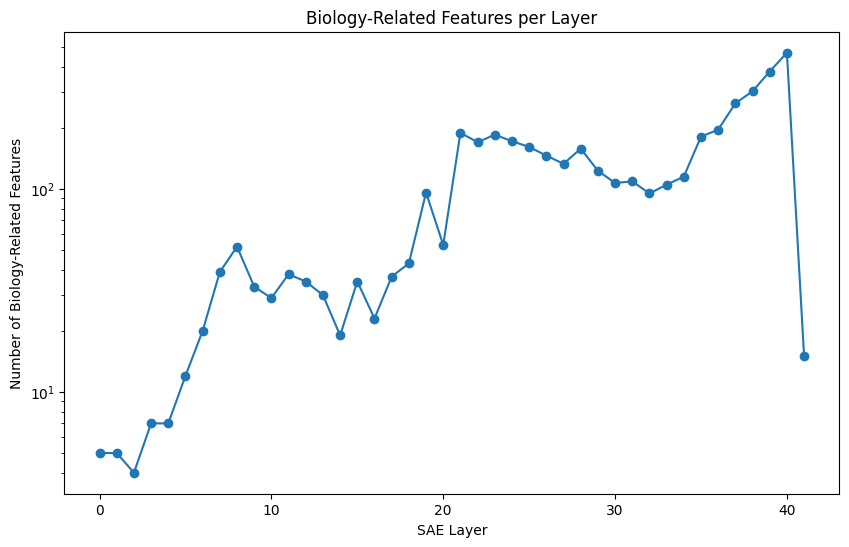

In [14]:
bio_related_sums = []
for layer in sae_layers:
    bio_related_sum = explanation_dfs[layer]["bio_related"].sum()
    bio_related_sums.append(bio_related_sum)

plt.figure(figsize=(10,6))
plt.plot(range(len(sae_layers)), bio_related_sums, marker="o")
plt.xlabel("SAE Layer")
plt.ylabel("Number of Biology-Related Features")
plt.yscale("log")
plt.title("Biology-Related Features per Layer")
# plt.xticks(range(len(sae_layers)), [f"Layer {i}" for i in range(len(sae_layers))])
plt.show()

In [77]:
bio_mc_task.reset_loaders()

In [78]:
def get_mc_batch_sae_acts(batch, sae_layers, sae_dict):
    tokenized_batch = left_tokenizer(batch["prompt"], return_tensors="pt", padding=True)
    output = model(tokenized_batch["input_ids"].cuda(), attention_mask=tokenized_batch["attention_mask"].cuda(), output_hidden_states=True)
    # print(f"{tokenized_batch['input_ids'][:, -1]=}")
    acts = {}
    sae_acts = {}
    for layer in sae_layers:
        # num_subject_tokens = 0
        total_hidden_states = output.hidden_states[layer+1]
        # print(f"{total_hidden_states.shape=}")
        acts[layer] = total_hidden_states[:, -1]
        sae_acts[layer] = sae_dict[layer].encode(acts[layer])
    return sae_acts

# does every MCQ prompt activate at least one bio-related feature?
use_mc_data = True
per_prompt_bio_related_features = []
per_prompt_unrelated_features = []
with torch.no_grad():
    for batch_idx in tqdm(range(num_batches)):
        if use_mc_data:
            bio_mc_batch = bio_mc_task.get_batch()
            bio_sae_acts = get_mc_batch_sae_acts(bio_mc_batch, sae_layers, sae_dict)
        else:
            bio_batch = bio_task.get_batch()
            bio_sae_acts = get_batch_sae_acts(bio_batch, sae_layers, sae_dict)
        # injection_batch = injection_bio_task.get_batch()
        # injection_sae_acts = get_batch_sae_acts(injection_batch, sae_layers, sae_dict)
        
        # print("bio_sae_acts", bio_sae_acts[0].shape)
        number_bio_related_features = torch.zeros(len(bio_sae_acts[sae_layers[0]]))
        number_unrelated_features = torch.zeros(len(bio_sae_acts[sae_layers[0]]))
        for layer in sae_layers:
            explanation_df = explanation_dfs[layer]
            nonzero_feature_indices = np.where(explanation_df["bio_related"] == True)[0]
            
            number_bio_related_features += (bio_sae_acts[layer].cpu()[:, nonzero_feature_indices] > 0).sum(dim=-1)
            number_unrelated_features += (bio_sae_acts[layer].cpu() > 0).sum(dim=-1) - (bio_sae_acts[layer].cpu()[:, nonzero_feature_indices] > 0).sum(dim=-1)
        per_prompt_bio_related_features.append(number_bio_related_features)
        per_prompt_unrelated_features.append(number_unrelated_features)

per_prompt_bio_related_features = torch.cat(per_prompt_bio_related_features, dim=0)
per_prompt_unrelated_features = torch.cat(per_prompt_unrelated_features, dim=0)
# num_bio_related_features_activated = torch.cat(num_bio_related_features_activated, dim=0)

  0%|          | 0/21 [00:00<?, ?it/s]

In [79]:
per_prompt_bio_related_features

tensor([347., 356., 355., 365., 275., 326., 361., 334., 311., 334., 383., 313.,
        295., 341., 301., 340., 333., 362., 363., 302., 326., 372., 402., 313.,
        370., 394., 290., 342., 343., 317., 330., 357., 358., 312., 366., 340.,
        337., 330., 369., 338., 325., 358., 312., 378., 358., 342., 350., 321.,
        297., 354., 285., 343., 374., 344., 364., 321., 324., 318., 282., 346.,
        353., 442., 317., 326., 296., 334., 345., 367., 343., 359., 338., 354.,
        305., 335., 325., 341., 306., 325., 315., 298., 361., 378., 399., 306.,
        360., 286., 327., 344., 311., 368., 345., 354., 322., 342., 281., 381.,
        366., 354., 305., 431., 355., 328., 310., 319., 309., 307., 306., 328.,
        408., 381., 363., 331., 297., 388., 366., 348., 360., 281., 323., 324.,
        334., 335., 384., 372., 312., 294., 305., 314., 314., 289., 333., 313.,
        290., 306., 324., 334., 381., 331., 427., 327., 325., 322., 292., 316.,
        315., 324., 289., 300., 334., 34

## Store all bio features activated by each fact

In [89]:
bio_mc_task = WMDP_UnlearnMCTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=False, split=split, train_test_split=False, criterion="cross_entropy", injection_task=False, model_type=None)
num_batches = int(math.ceil(len(bio_mc_task.train_dataset) / batch_size))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

In [100]:
bio_mc_task.reset_loaders()
use_mc_data = True
all_per_prompt_bio_related_features = []
questions = []
with torch.no_grad():
    for batch_idx in tqdm(range(num_batches)):
        if use_mc_data:
            bio_mc_batch = bio_mc_task.get_batch()
            bio_sae_acts = get_mc_batch_sae_acts(bio_mc_batch, sae_layers, sae_dict)
        else:
            bio_batch = bio_task.get_batch()
            bio_sae_acts = get_batch_sae_acts(bio_batch, sae_layers, sae_dict)
        questions += bio_mc_batch["question"]
        # injection_batch = injection_bio_task.get_batch()
        # injection_sae_acts = get_batch_sae_acts(injection_batch, sae_layers, sae_dict)
        
        # print("bio_sae_acts", bio_sae_acts[0].shape)
        for i in range(len(bio_sae_acts[sae_layers[0]])): # for each fact in batch
            layer_related_features = {}
            for layer in sae_layers:
                explanation_df = explanation_dfs[layer]
                related_feature_indices = np.where(explanation_df["bio_related"] == True)[0]
                related_feature_mask = torch.zeros(bio_sae_acts[layer].shape[-1]).cuda()
                related_feature_mask[related_feature_indices] = 1

                bio_related_features = (bio_sae_acts[layer][i, :] > 0) & related_feature_mask.bool()
                prompt_related_features = np.where(bio_related_features.cpu())[0]
                layer_related_features[layer] = prompt_related_features.tolist()

            all_per_prompt_bio_related_features.append(layer_related_features)


  0%|          | 0/45 [00:00<?, ?it/s]

In [106]:
import json
per_prompt_related_feature_df = pd.DataFrame({"question": questions, "per_prompt_related_features": all_per_prompt_bio_related_features})
per_prompt_related_feature_df.to_csv("saes/bio_mcq_related_features.csv")
per_prompt_related_feature_df["per_prompt_related_features"] = per_prompt_related_feature_df["per_prompt_related_features"].apply(lambda x: json.dumps(x))

# import json
# for prompt_idx in range(len(all_per_prompt_bio_related_features)):
#     json_reconstruction = json.loads(json.dumps(all_per_prompt_bio_related_features[prompt_idx]))
#     total_features = sum(len(v) for v in json_reconstruction.values())
#     total_original_features = sum(len(v) for v in all_per_prompt_bio_related_features[prompt_idx].values())
#     assert total_features == total_original_features, f"Total features: {total_features}, Total original features: {total_original_features}"

In [108]:
# save
from datasets import load_dataset, Dataset, DatasetDict
overall_dataset = {}
for split_idx in [0, 1, 2, 3, 4]:
    bio_dataset = load_dataset("PhillipGuo/wmdp-deduped-unlearn", "wmdp-bio-retrain", split=f"split{split_idx}")

    bio_df = bio_dataset.to_pandas()
    print(f"Original length: {len(bio_df)}")
    bio_df = bio_df.merge(per_prompt_related_feature_df, on="question")
    print(f"New length: {len(bio_df)}")
    overall_dataset[f"split{split_idx}"] = Dataset.from_pandas(bio_df)

overall_dataset = DatasetDict(overall_dataset)
overall_dataset.push_to_hub("PhillipGuo/wmdp-deduped-unlearn", "wmdp-bio-retrain")

Original length: 71
New length: 71
Original length: 71
New length: 71
Original length: 71
New length: 71
Original length: 71
New length: 71
Original length: 71
New length: 71


## What happens if we clamp these per-prompt features?

In [115]:
bio_mc_task = WMDP_UnlearnMCTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=False, split=split, train_test_split=False, criterion="cross_entropy", injection_task=False, model_type=None)

Generating split0 split:   0%|          | 0/71 [00:00<?, ? examples/s]

Generating split1 split:   0%|          | 0/71 [00:00<?, ? examples/s]

Generating split2 split:   0%|          | 0/71 [00:00<?, ? examples/s]

Generating split3 split:   0%|          | 0/71 [00:00<?, ? examples/s]

Generating split4 split:   0%|          | 0/71 [00:00<?, ? examples/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

In [142]:
def clamp_sae_feature(act, sae, features, clamp_value=0):
    if isinstance(features, int):
        features = [features]
    feature_w = sae.W_enc[:, features] # [hidden, n_features]
    feature_b = sae.b_enc[features] # [n_features]
    threshold = sae.threshold[features] # [n_features]
    feature_vec = sae.W_dec[features] # [n_features, hidden]

    # print(f"{feature_w.shape=}, {feature_b.shape=}, {threshold.shape=}, {feature_vec.shape=}, {act.shape=}")

    with torch.amp.autocast(device_type="cuda", dtype=dtype):
        feature_acts = einops.einsum(act, feature_w, "... hidden, hidden n_features -> ... n_features") + feature_b
        # print(f"{feature_acts.shape=}")
        # feature_acts = (feature_acts > threshold) * feature_acts
        clamped_feature_diff = torch.where(feature_acts > threshold, clamp_value - feature_acts, 0)
        # print(f"{clamped_feature_diff.shape=}")
    # if feature act is 0, then don't need to do anything
    # if feature act is positive, then need to clamp it: can replicate by subtracting (feature_acts - clamp_value) * feature_w_dec
        output = act + einops.einsum(clamped_feature_diff, feature_vec, "... n_features, n_features hidden -> ... hidden")
    return output

def clamp_sae_feature_decode(act, sae, features, clamp_value=0):
    sae_acts = sae.encode(act)
    if isinstance(features, int):
        features = [features]
    # print(f"{sae_acts.shape=}")
    # print(f"{sae_acts[..., features]=}")
    with torch.amp.autocast(device_type="cuda", dtype=dtype):
        feature_clamped_acts = torch.where(sae_acts[..., features] > 0, clamp_value, 0.)
        sae_acts[..., features] = feature_clamped_acts
        output = sae.decode(sae_acts).to(dtype)
    return output

def get_hook(sae, features, clamp_value=0, decode=False):
    def clamp_hook(module, inputs, output):
        if decode:
            new_output = (clamp_sae_feature_decode(output[0], sae, features, clamp_value=clamp_value),) + output[1:]
        else:
            new_output = (clamp_sae_feature(output[0], sae, features, clamp_value=clamp_value),) + output[1:]
        return new_output
    return clamp_hook

@contextlib.contextmanager
def temporary_forward_hook(module, hook_fn):
    """
    Registers the given hook function to `module` and removes it on exit.
    """
    handle = module.register_forward_hook(hook_fn)
    try:
        yield
    finally:
        handle.remove()

@contextlib.contextmanager
def temporary_forward_hooks(module_hook_pairs):
    """
    Registers multiple hook functions to multiple modules and removes them on exit.
    
    Args:
        module_hook_pairs: List of (module, hook_fn) tuples
    """
    handles = [module.register_forward_hook(hook_fn) 
              for module, hook_fn in module_hook_pairs]
    try:
        yield
    finally:
        for handle in handles:
            handle.remove()

In [155]:
clamp_value = 0
answer_tokens = tokenizer([' A', ' B', ' C', ' D'], return_tensors="pt", add_special_tokens=False).input_ids[:, -1]
from tasks.general_capabilities.MCTask_redo import run_general_evals


rel_probs_without_clamping = []
rel_probs_with_clamping = []
abs_probs_without_clamping = []
abs_probs_with_clamping = []
num_features_clamped = []
for idx in tqdm(range(len(bio_mc_task.train_dataset))):
    entry = bio_mc_task.train_dataset[idx]
    feature_dict = json.loads(entry["per_prompt_related_features"])
    feature_dict = {int(k): v for k, v in feature_dict.items()}
    num_features_clamped.append(sum(len(v) for v in feature_dict.values()))
    # print(feature_dict)
    tokenized = tokenizer(entry["prompt"], return_tensors="pt")
    # print(tokenized["input_ids"].shape)
    correct_answer_idx = entry["answer"]


    transformer_layers = model.model.layers

    module_hook_pairs = [
        (transformer_layers[layer_idx], 
         get_hook(sae_dict[layer_idx], features, clamp_value=clamp_value))
        for layer_idx, features in feature_dict.items()
    ]
    with torch.no_grad():
        with temporary_forward_hooks(module_hook_pairs):
            output = model(tokenized["input_ids"].cuda(), 
                         attention_mask=tokenized["attention_mask"].cuda()).logits[0, -1, :]
            
            # mmlu = run_general_evals(model, model_type=model_type, evals_to_include=["MMLU"], verbose=True, batch_size=5, device="cuda")
        probs = torch.softmax(output, dim=-1)
        all_answer_probs = probs[answer_tokens]
        rel_answer_prob = all_answer_probs[correct_answer_idx] / all_answer_probs.sum()
        rel_probs_with_clamping.append(rel_answer_prob)
        abs_probs_with_clamping.append(all_answer_probs[correct_answer_idx])


        output = model(tokenized["input_ids"].cuda(), 
                        attention_mask=tokenized["attention_mask"].cuda()).logits[0, -1, :]
            
        probs = torch.softmax(output, dim=-1)
        all_answer_probs = probs[answer_tokens]
        rel_answer_prob = all_answer_probs[correct_answer_idx] / all_answer_probs.sum()
        rel_probs_without_clamping.append(rel_answer_prob)
        abs_probs_without_clamping.append(all_answer_probs[correct_answer_idx])




  0%|          | 0/355 [00:00<?, ?it/s]

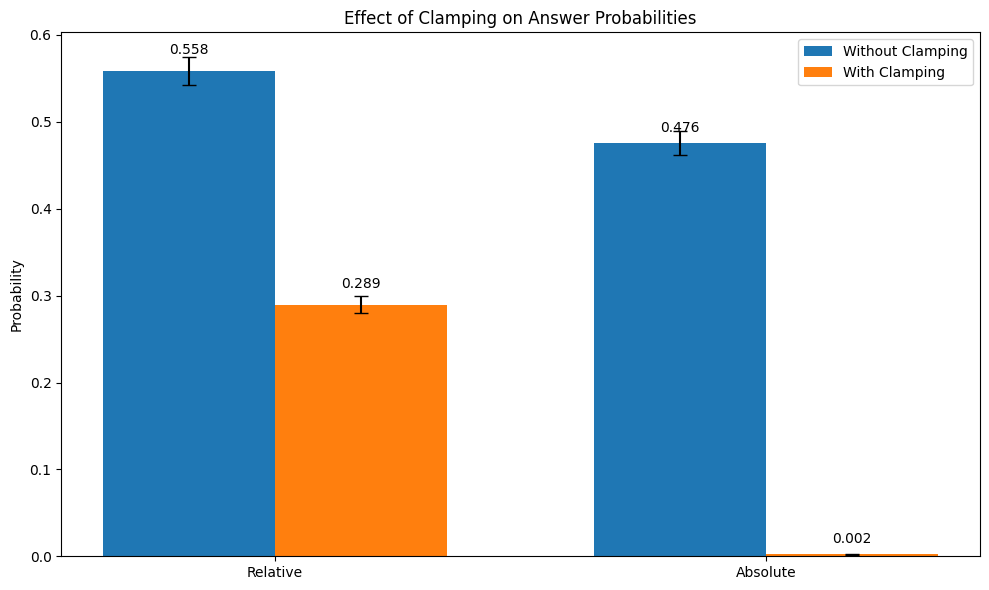


Statistical Tests:
Relative probabilities t-test: p=3.771e-46
Absolute probabilities t-test: p=4.640e-113


In [157]:
import matplotlib.pyplot as plt
import numpy as np

# Convert lists of tensors to numpy arrays
rel_probs_without = torch.stack(rel_probs_without_clamping).cpu().float().numpy()
rel_probs_with = torch.stack(rel_probs_with_clamping).cpu().float().numpy()
abs_probs_without = torch.stack(abs_probs_without_clamping).cpu().float().numpy()
abs_probs_with = torch.stack(abs_probs_with_clamping).cpu().float().numpy()

# Calculate means and standard errors
means = [
    np.mean(rel_probs_without),
    np.mean(rel_probs_with),
    np.mean(abs_probs_without),
    np.mean(abs_probs_with)
]

sems = [
    np.std(rel_probs_without) / np.sqrt(len(rel_probs_without)),
    np.std(rel_probs_with) / np.sqrt(len(rel_probs_with)),
    np.std(abs_probs_without) / np.sqrt(len(abs_probs_without)),
    np.std(abs_probs_with) / np.sqrt(len(abs_probs_with))
]

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(2)
width = 0.35

ax.bar(x - width/2, [means[0], means[2]], width, label='Without Clamping',
       yerr=[sems[0], sems[2]], capsize=5)
ax.bar(x + width/2, [means[1], means[3]], width, label='With Clamping',
       yerr=[sems[1], sems[3]], capsize=5)

ax.set_ylabel('Probability')
ax.set_title(f'Effect of Clamping on Answer Probabilities, clamping average of {np.mean(num_features_clamped):.2f} features')
ax.set_xticks(x)
ax.set_xticklabels(['Relative', 'Absolute'])
ax.legend()

# Add value labels on top of each bar
for i, v in enumerate([means[0], means[2]]):
    ax.text(i - width/2, v + sems[i], f'{v:.3f}', ha='center', va='bottom')
for i, v in enumerate([means[1], means[3]]):
    ax.text(i + width/2, v + sems[i], f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print statistical significance
from scipy import stats

rel_ttest = stats.ttest_rel(rel_probs_without, rel_probs_with)
abs_ttest = stats.ttest_rel(abs_probs_without, abs_probs_with)

print("\nStatistical Tests:")
print(f"Relative probabilities t-test: p={rel_ttest.pvalue:.3e}")
print(f"Absolute probabilities t-test: p={abs_ttest.pvalue:.3e}")